# Anomnaly Detection

This notebook was created as an extension to the `evaluate_detection.py` script.

In [1]:
# import
import pickle
import json
import yaml
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.ticker as ticker
# Inside your plotting function/loop
formatter = ticker.FormatStrFormatter('%.2f')  # Change to the desired format, e.g., '%.3f' for three decimal places

from fault_management_uds.plots import visualize_confusion, visualize_roc_auc, visualize_metric_matrix
from fault_management_uds.config import data_label_hue_map, data_label_hue_order, anomaly_hue_map, anomaly_hue_order


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import rain_gauge_color, condition_to_meta

2025-02-27 15:59:18.167 | INFO     | fault_management_uds.config:<module>:15 - PROJ_ROOT path is: /work3/s194262/GitHub/fault_management_uds
2025-02-27 15:59:19.487826: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 15:59:20.051785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740668360.118827  503867 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740668360.136620  503867 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
20

In [2]:
model_save_path = 'transformer/7_anomalous/iteration=0_250206_0903 copy'
data_type = 'val'  

model_save_folder = MODELS_DIR / model_save_path #/ '1_split'
anomalous_path = MODELS_DIR / model_save_path / '1_split' / 'anomalous'
results_folder = anomalous_path / data_type

eval_path = MODELS_DIR / model_save_path / '1_split' / 'evaluation'
eval_folder = eval_path / data_type


In [3]:
# Load the results
with open(results_folder / 'anomaly_prediction_results_full.pkl', 'rb') as f:
    results = pickle.load(f)

print(results.keys())

config = yaml.load(open(model_save_folder / 'config.yaml', 'r'), Loader=yaml.Loader)

dict_keys(['Valid index', 'Starttime', 'Data label', 'Actual', 'Combined', 'Target', 'Residuals', 'Final hidden', 'IG'])


In [4]:
# rename the key in dict
results['Final Hidden'] = results.pop('Final hidden')
results['Multi-Feature'] = results.pop('Combined')
results['Data Label'] = results.pop('Data label')

In [5]:
methods = ['Target', 'Final Hidden', 'Residuals', 'IG', 'Multi-Feature']

In [6]:
# set save folder
save_folder = eval_folder / 'anomaly_detection'
os.makedirs(save_folder, exist_ok=True)

# Thresholding

In [7]:
if data_type == 'val':
    optimal_thresholds = {}
    for i, key in enumerate(methods):
        # ROC curve
        fpr, tpr, thresholds = roc_curve(results['Actual'], results[key]['Decision Function'])

        # Don't use the first and last threshold
        fpr = fpr[1:-1]
        tpr = tpr[1:-1]
        thresholds = thresholds[1:-1]

        # Calculate Youden's index
        youden_index = tpr - fpr
        optimal_threshold = thresholds[np.argmax(youden_index)]

        print(f'Optimal Threshold for {key}: {optimal_threshold}')
        optimal_thresholds[key] = optimal_threshold

    # Save the optimal thresholds
    with open(anomalous_path / 'optimal_thresholds.pkl', 'wb') as f:
        pickle.dump(optimal_thresholds, f)

# Load the optimal thresholds, ensure they exist
if os.path.exists(anomalous_path / 'optimal_thresholds.pkl'):
    with open(anomalous_path / 'optimal_thresholds.pkl', 'rb') as f:
        optimal_thresholds = pickle.load(f)
else:
    raise FileNotFoundError('Optimal thresholds not found')

# insert the optimal threshold to the results
for key in methods:
    results[key]['Optimal Threshold'] = optimal_thresholds[key]
    # Update the predicted labels
    results[key]['Predicted'] = results[key]['Decision Function'] > optimal_thresholds[key]

Optimal Threshold for Target: 0.045446631864508036
Optimal Threshold for Final Hidden: 0.17253181202457324
Optimal Threshold for Residuals: 0.136440749578284
Optimal Threshold for IG: -0.046551006196230205
Optimal Threshold for Multi-Feature: -0.02653451620469699


# Sigma-3

In [8]:
# add the sigma-3 results
starttimes = pd.to_datetime(results['Starttime'])

with open(eval_folder / f'output.pkl', 'rb') as f:
    output = pickle.load(f)

timestamps = output['timestamps']
# use only the first step

residuals = abs(output['predictions'][:,:,0].flatten() - output['targets'][:,:,0].flatten())

# extract relevant residuals based on the starttimes
residuals = residuals[np.isin(timestamps, starttimes)]

# mask = np.in1d(timestamps, starttimes)  # Create a boolean mask
# residuals = residuals[mask]  # Apply the mask to extract relevant residuals

# starttimes_set = set(starttimes)
# mask = np.array([ts in starttimes_set for ts in timestamps])
# residuals = residuals[mask]

# use the 3-sigma rule to determine the anomalies
sigma = 3
mean = np.mean(residuals)
std = np.std(residuals)

results['Sigma-3'] = {
    'Predicted': residuals > mean + sigma * std,
    'Decision Function': residuals,
    'Optimal Threshold': mean + sigma * std
}


methods = methods + ['Sigma-3']

# Confusion Matrix

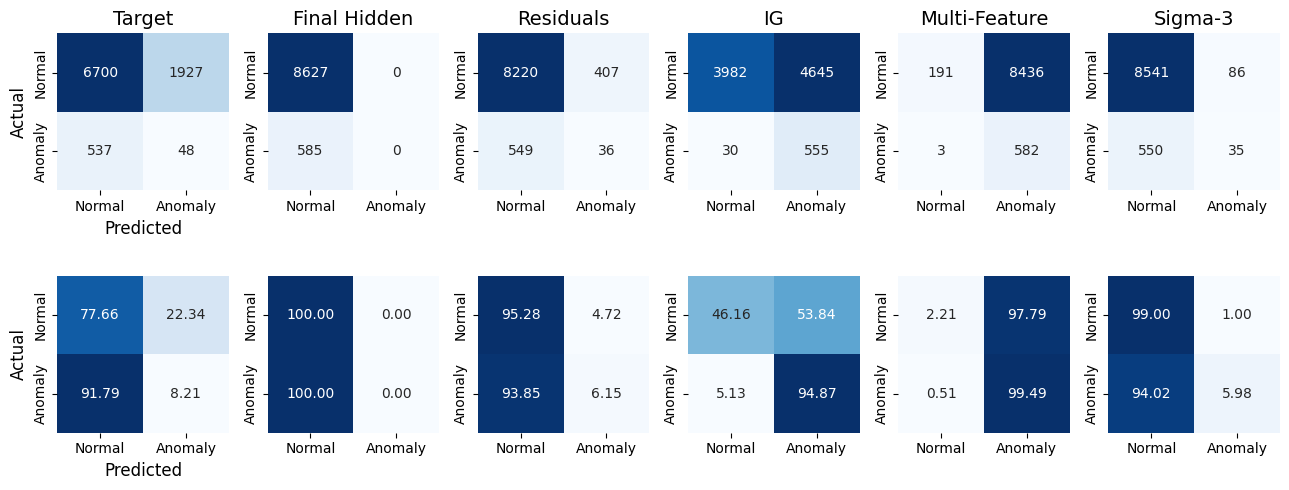

In [9]:
# Overall results
fig, axes = plt.subplots(2, len(methods), figsize=(13, 5))
auc_scores = {}
for i, key in enumerate(methods):
    # Confusion matrix
    conf_matrix = confusion_matrix(results['Actual'], results[key]['Predicted'])
    axes[0, i] = visualize_confusion(axes[0, i], i, key, conf_matrix, 'd', 'Blues')
    # add header
    # Percentage confusion matrix
    conf_matrix = confusion_matrix(results['Actual'], results[key]['Predicted'])
    conf_matrix = conf_matrix.astype('float') / (conf_matrix.sum(axis=1)[:, np.newaxis] + 1e-9) * 100
    axes[1, i] = visualize_confusion(axes[1, i], i, ' ', conf_matrix, ".2f", 'Blues')

plt.tight_layout()
plt.savefig(save_folder / 'cm_overall.png')
plt.show()
plt.close()

# ROC Curve

In [10]:
def visualize_roc_auc(ax, i, key, fpr, tpr, roc_auc, optimal_fpr=None, optimal_tpr=None):   
    ax.plot(fpr, tpr, color='darkorange', lw=2, label="ROC")#, label='AUC: %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', label='Random')
    # plot optimal if specified
    if optimal_fpr is not None and optimal_tpr is not None:
        ax.plot(optimal_fpr, optimal_tpr, marker='o', markersize=4, color='navy', label='Threshold')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    if i == 0:
        ax.set_ylabel('TPR', fontsize=12)
        ax.set_xlabel('FPR', fontsize=12)
    ax.legend(loc='lower right')
    ax.set_title(key, fontsize=14)
    return ax


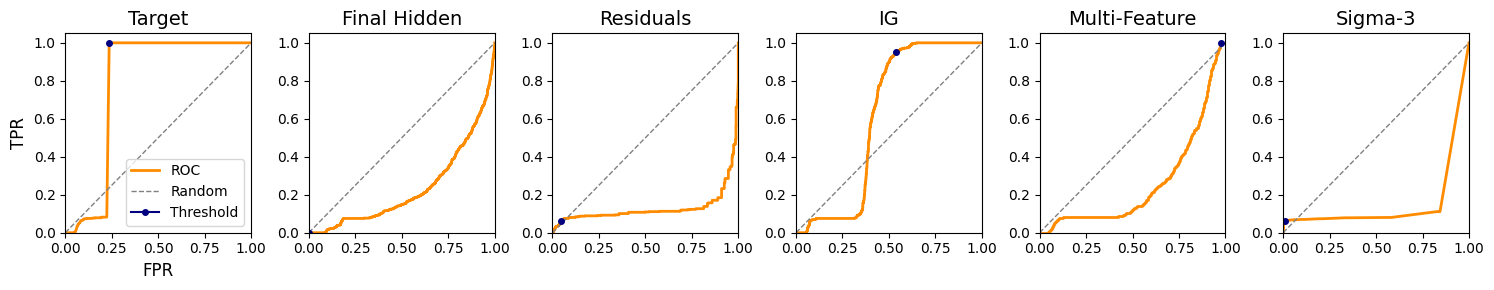

In [11]:
# Visualize the results
# Overall results
fig, axes = plt.subplots(1, len(methods), figsize=(15, 3))
auc_scores = {}
for i, key in enumerate(methods):
    # ROC curve
    fpr, tpr, thresholds = roc_curve(results['Actual'], results[key]['Decision Function'])
    roc_auc = auc(fpr, tpr)
    auc_scores[key] = {'Overall': roc_auc}
    # Find the index based on the optimal threshold
    optimal_threshold = results[key]['Optimal Threshold']
    optimal_index = np.argmin(np.abs(thresholds - optimal_threshold)) # Find the index of the optimal threshold based on smallest difference
    optimal_fpr = fpr[optimal_index]
    optimal_tpr = tpr[optimal_index]
    axes[i] = visualize_roc_auc(axes[i], i, key, fpr, tpr, roc_auc, optimal_fpr, optimal_tpr)
    # remove legend
    if i != 0:
        axes[i].legend().remove()
plt.tight_layout()
plt.savefig(save_folder / 'roc_auc_overall.png')
plt.show()
plt.close()


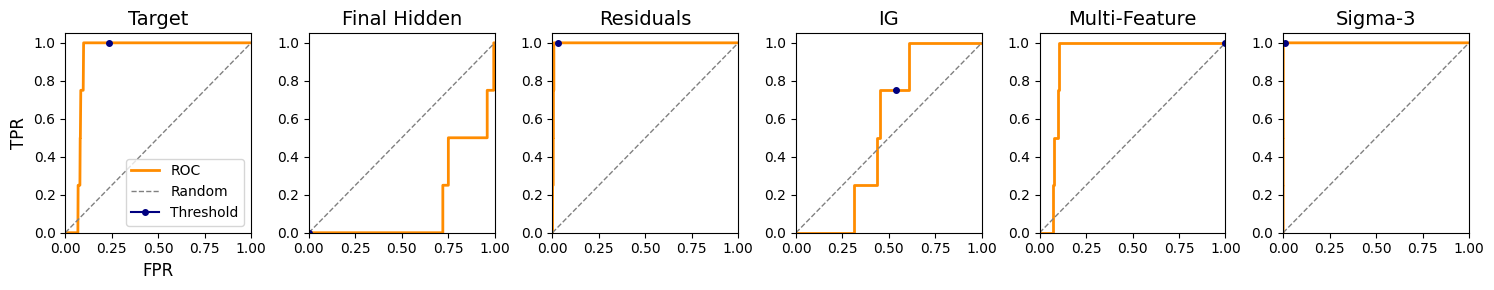

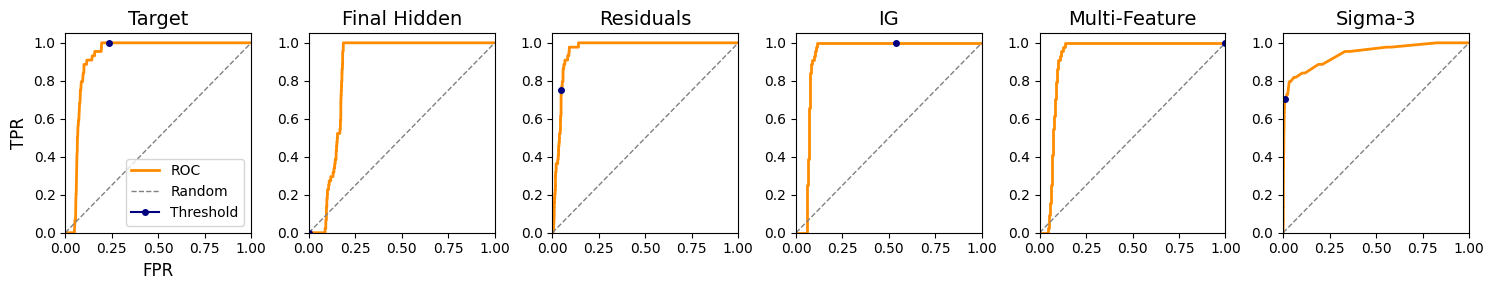

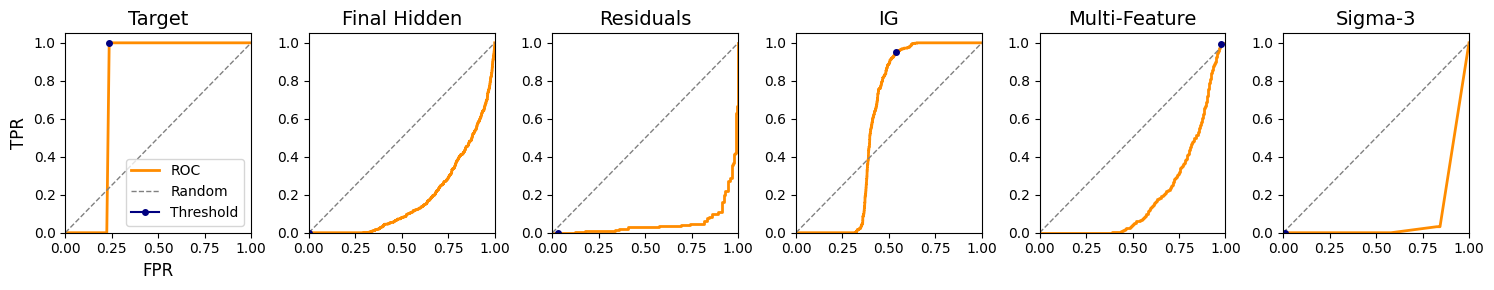

No TP for Offset in Target
No TP for Offset in Final Hidden
No TP for Offset in Residuals
No TP for Offset in IG
No TP for Offset in Multi-Feature
No TP for Offset in Sigma-3


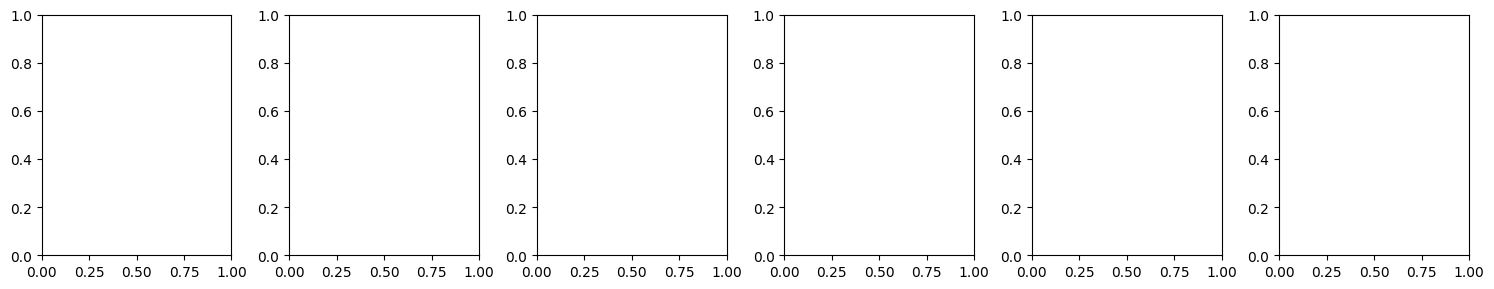

No TP for Drift in Target
No TP for Drift in Final Hidden
No TP for Drift in Residuals
No TP for Drift in IG
No TP for Drift in Multi-Feature
No TP for Drift in Sigma-3


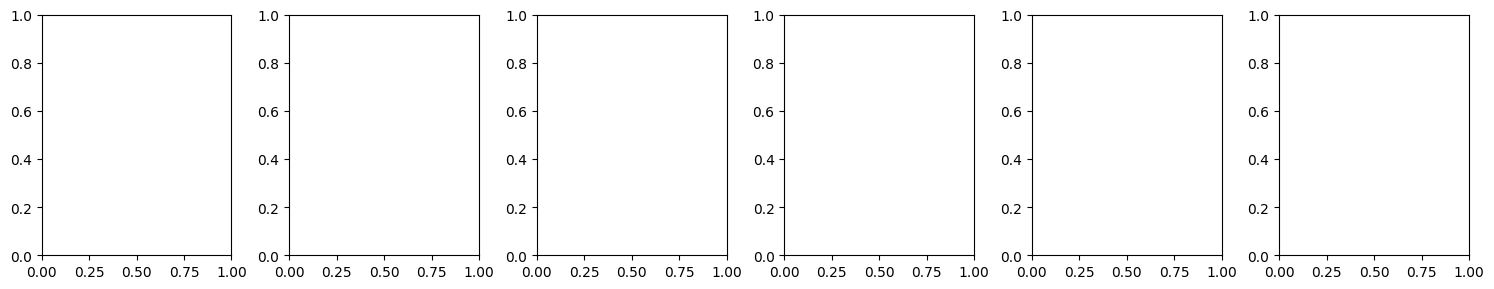

In [12]:

# For each anomaly
data_label = results['Data Label']
for label in data_label_hue_order[::-1]:
    if label == 'Original':
        continue
    mask = (np.array(data_label) == label) | (np.array(data_label) == 'Original')
    
    fig, axes = plt.subplots(1, len(methods), figsize=(15, 3)) # plot

    for i, key in enumerate(methods):
        # ROC curve
        # check if any tp
        if sum(results['Actual'][mask]) == 0:
            print(f'No TP for {label} in {key}')
            auc_scores[key][label] = 0  
            continue
        else:
            fpr, tpr, thresholds = roc_curve(results['Actual'][mask], results[key]['Decision Function'][mask])
            roc_auc = auc(fpr, tpr)
            auc_scores[key][label] = roc_auc
            
        # Find the index based on the optimal threshold
        optimal_threshold = results[key]['Optimal Threshold']
        optimal_index = np.argmin(np.abs(thresholds - optimal_threshold)) # Find the index of the optimal threshold based on smallest difference
        optimal_fpr = fpr[optimal_index]
        optimal_tpr = tpr[optimal_index]
        axes[i] = visualize_roc_auc(axes[i], i, key, fpr, tpr, roc_auc, optimal_fpr, optimal_tpr)
        # remove legend
        if i != 0:
            axes[i].legend().remove()
    plt.tight_layout()
    plt.savefig(save_folder / f'roc_auc_{label}.png')
    plt.show()
    plt.close()


# AUC metric

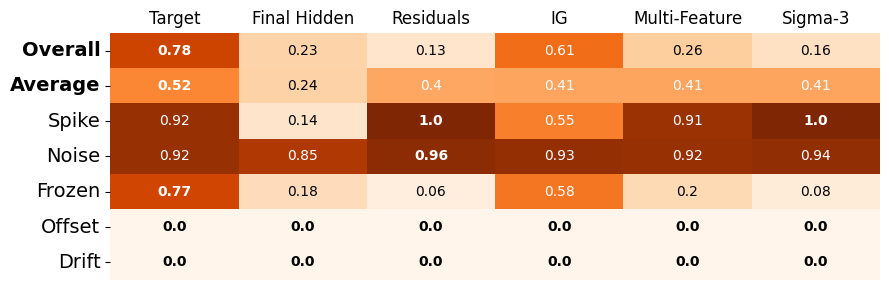

In [13]:
# row ordering
row_order = data_label_hue_order[1:] + ['Average', 'Overall']

# AUC
metric_df = pd.DataFrame(auc_scores)
# Calculate the average AUC as well
metric_df.loc['Average'] = metric_df.loc[data_label_hue_order[1:]].mean()
metric_df = metric_df.loc[row_order]
visualize_metric_matrix('AUC', metric_df, 'Oranges', 2, suffix=None, figsize=(9, 3), save_folder=save_folder)
visualize_metric_matrix('AUC', metric_df, 'Oranges', 2, suffix=None, figsize=(9, 3), save_folder=None)


# Decision Function

In [14]:
methods = methods[:-1] # remove sigma-3

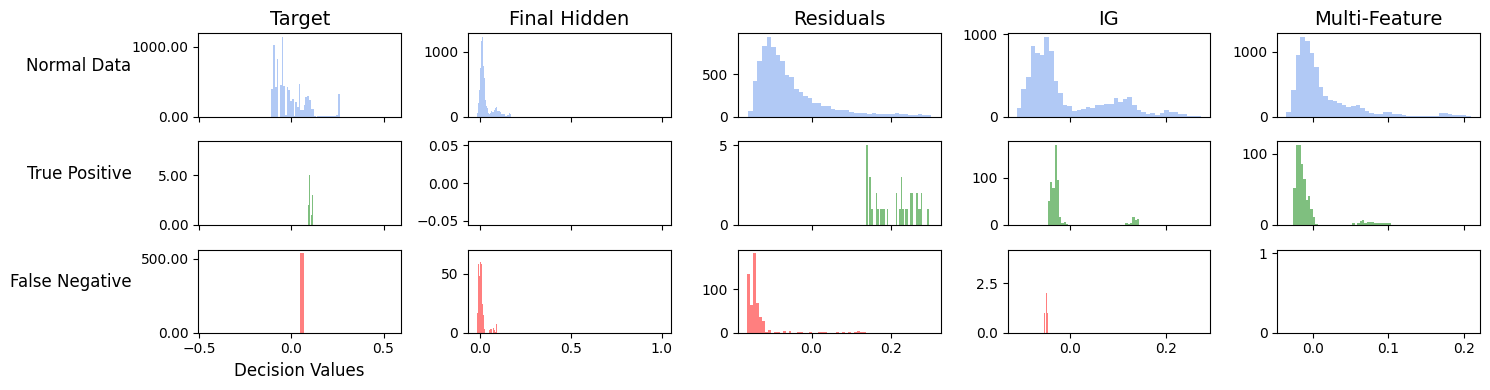

In [15]:
actual = results['Actual']

fig, axes = plt.subplots(3, len(methods), figsize=(15, 4), sharex="col")

# Normal Data, Predicted Synthetic, Not Predicted Synthetic
for i, key in enumerate(methods):
    _predicted_synthetic = (results[key]['Predicted'].astype(int) == 1) & (actual.astype(int) == 1)
    predicted_synthetic = results[key]['Decision Function'][_predicted_synthetic]
    _not_predicted_synthetic = (results[key]['Predicted'].astype(int) == 0) & (actual.astype(int) == 1)
    not_predicted_synthetic = results[key]['Decision Function'][_not_predicted_synthetic]
    _normal_data = (actual.astype(int) == 0)
    normal_data = results[key]['Decision Function'][_normal_data]
    # Visualize the distribution of the decision function
    axes[0, i].hist(normal_data, bins=40, color='cornflowerblue', alpha=0.5)
    axes[1, i].hist(predicted_synthetic, bins=40, color='green', alpha=0.5)
    axes[2, i].hist(not_predicted_synthetic, bins=40, color='red', alpha=0.5)
    axes[0, i].set_title(key, fontsize=14)
    
axes[0, 0].set_ylabel('Normal Data', fontsize=12, rotation=0, labelpad=0, ha='right')
axes[1, 0].set_ylabel('True Positive', fontsize=12, rotation=0, labelpad=0, ha='right')
axes[2, 0].set_ylabel('False Negative', fontsize=12, rotation=0, labelpad=0, ha='right')
axes[0, 0].yaxis.set_major_formatter(formatter)
axes[1, 0].yaxis.set_major_formatter(formatter)
axes[2, 0].yaxis.set_major_formatter(formatter)
axes[2, 0].set_xlabel('Decision Values', fontsize=12)
fig.align_ylabels()  # ensures all y-labels are properly aligned

plt.tight_layout()
plt.savefig(save_folder / 'decision_function_distribution.png')
plt.show()
plt.close()

#### Only multi feature

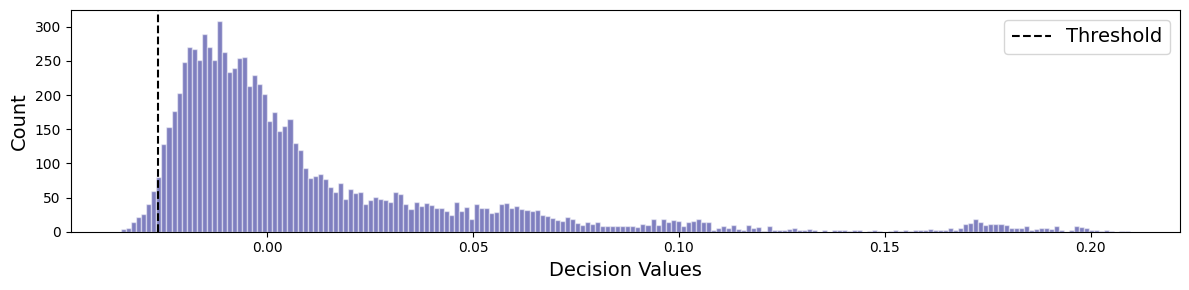

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3), sharex=True)

method = "Multi-Feature"
normal_data = results[method]['Decision Function']#[_normal_data]
ax.hist(normal_data, bins=200, color='navy', alpha=0.5, edgecolor='white')
threshold = results[method]['Optimal Threshold']
ax.axvline(threshold, color='black', linestyle='--', label='Threshold')
ax.set_xlabel('Decision Values', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.legend(loc='upper right', fontsize=14)
#ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(save_folder / f'decision_function_{method}.png')
plt.show()
plt.close()

# Timing and Coverage

In [17]:
from fault_management_uds.synthetic.synthetic_generator import find_unterrupted_sequences

In [18]:
def get_coverage(predicted, anomaly_start_end):
    # Given start and end of anomalies, find how much of the anomaly is covered by the prediction
    # Find all indices where the value is 1
    ones_indices = np.where(predicted == 1)[0]
    # Find the closest index in both directions
    if len(ones_indices) == 0:
        # do not continue
        #raise ValueError("No anomalies detected")
        return [0] * len(anomaly_start_end)

    coverage = []

    for start, end in anomaly_start_end:
        # extract relevant data
        anomaly_data = predicted[start:end+1]
        
        # Coverage
        coverage.append(anomaly_data.sum() / len(anomaly_data))

    return coverage


def get_timing(predicted, anomaly_start_end, direction='start'):
    # Find all indices where the value is 1
    ones_indices = np.where(predicted == 1)[0]

    # Handle case with no detections
    if len(ones_indices) == 0:
        return [0] * len(anomaly_start_end)

    timing = []

    for i, (start, end) in enumerate(anomaly_start_end):
        if direction == 'start':
            # Filter indices that are after the start
            valid_indices = ones_indices[(ones_indices >= start) & (ones_indices <= end)]
            if valid_indices.size > 0:
                distances = np.abs(valid_indices - start)
                closest_index = valid_indices[np.argmin(distances)]
                timing.append(closest_index - start)
            # else:
            #     timing.append(np.inf)  # Use inf to indicate no proximity
        elif direction == 'end':
            # Filter indices that are before the end
            end_threshold = end + 60 # 60 minutes after the end
            valid_indices = ones_indices[(ones_indices >= start) & (ones_indices < end_threshold)]
            if valid_indices.size > 0:
                distances = np.abs(valid_indices - end)
                closest_index = valid_indices[np.argmin(distances)]
                timing.append(closest_index - end)
            # else:
            #     timing.append(np.inf)  # Use inf to indicate no proximity
        else:
            raise ValueError("Invalid direction specified. Use 'start' or 'end'.")

    return timing

In [19]:
# Get the start and end of each anomaly
indices_of_ones = [index for index, value in enumerate(results['Actual']) if value == 1]
_, anomaly_start_end = find_unterrupted_sequences(indices_of_ones, 0)

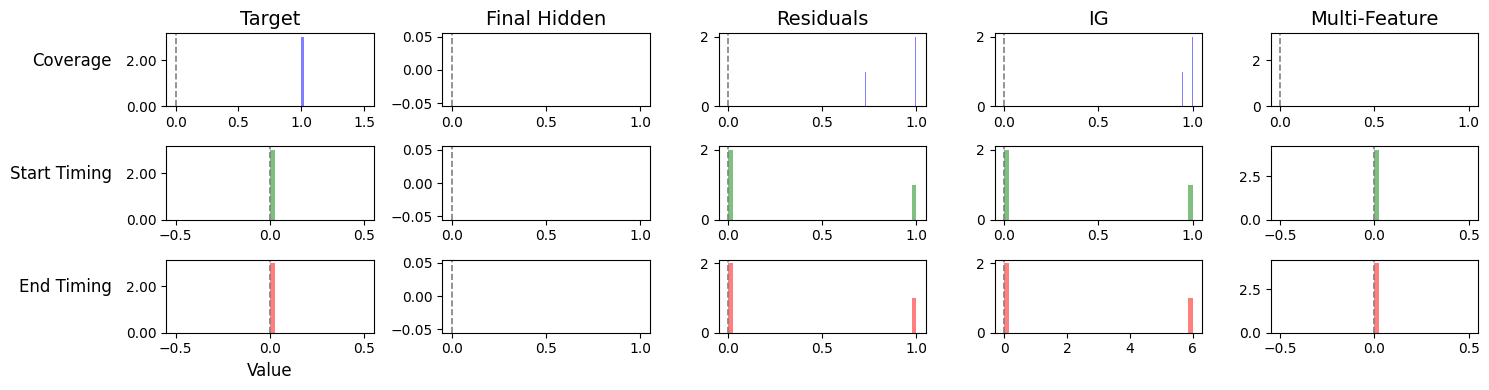

In [20]:
fig, axes = plt.subplots(3, len(methods), figsize=(15, 4))#, sharey=True)

coverage_scores = {}
timing_start_scores = {}
timing_end_scores = {}

for i, key in enumerate(methods):
    coverage = get_coverage(results[key]['Predicted'], anomaly_start_end)
    # for timing, we only want those that are detected
    _anomaly_start_end = [anomaly_start_end[i] for i, cov in enumerate(coverage) if cov > 0]
    start_timing = get_timing(results[key]['Predicted'], _anomaly_start_end, direction='start')
    end_timing = get_timing(results[key]['Predicted'], _anomaly_start_end, direction='end')
    # filter coverage as well
    coverage = [cov for cov in coverage if cov > 0]

    # Store the results
    coverage_scores[key] = {'Overall': np.mean(coverage) if len(coverage) > 0 else 0}
    timing_start_scores[key] = {'Overall': np.mean(start_timing) if len(start_timing) > 0 else 0}
    timing_end_scores[key] = {'Overall': np.mean(end_timing) if len(end_timing) > 0 else 0}
    

    # Visualize the distribution of the decision function
    axes[0, i].hist(coverage, bins=40, color='blue', alpha=0.5)
    axes[1, i].hist(start_timing, bins=40, color='green', alpha=0.5)
    axes[2, i].hist(end_timing, bins=40, color='red', alpha=0.5)
    axes[0, i].set_title(key, fontsize=14)
    # Adding vertical line at x = 0
    for ax in axes[:, i]:  # For all three subplots
        ax.axvline(x=0, color='grey', linestyle='--', linewidth=1.2)
        # ax.text(0.05, ax.get_ylim()[1]*0.9, 'Perfect Timing', color='black', fontsize=10,
        #         horizontalalignment='center', verticalalignment='center')  # Add text label

axes[0, 0].set_ylabel('Coverage', fontsize=12, rotation=0, labelpad=10, ha='right')
axes[1, 0].set_ylabel('Start Timing', fontsize=12, rotation=0, labelpad=10, ha='right')
axes[2, 0].set_ylabel('End Timing', fontsize=12, rotation=0, labelpad=10, ha='right')
axes[0, 0].yaxis.set_major_formatter(formatter)
axes[1, 0].yaxis.set_major_formatter(formatter)
axes[2, 0].yaxis.set_major_formatter(formatter)
axes[2, 0].set_xlabel('Value', fontsize=12)
fig.align_ylabels()  # ensures all y-labels are properly aligned

plt.tight_layout()
plt.savefig(save_folder / 'coverage_timing.png')
plt.show()
plt.close()


the `_anomaly_start_end` only considers classifications with at least 1 successful detection.

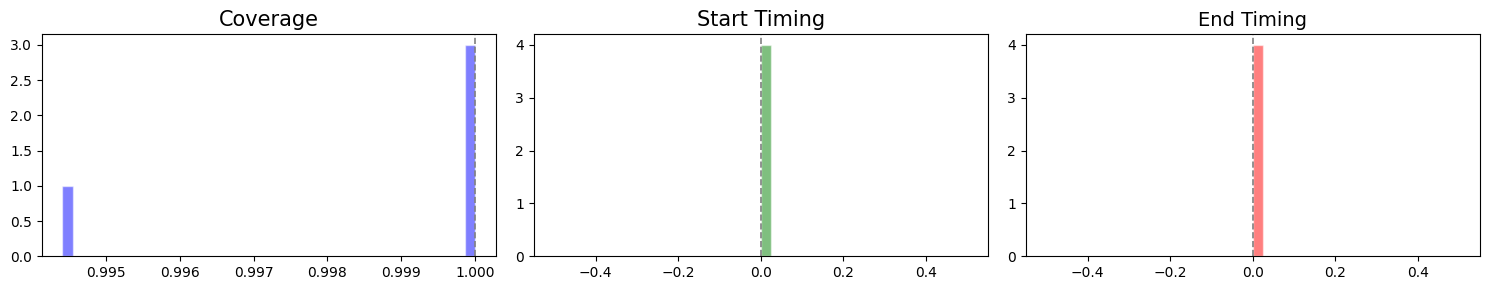

In [21]:
method = "Multi-Feature"

fig, axes = plt.subplots(1, 3, figsize=(15, 3))#, sharey=True)

coverage = get_coverage(results[method]['Predicted'], anomaly_start_end)
# for timing, we only want those that are detected
_anomaly_start_end = [anomaly_start_end[i] for i, cov in enumerate(coverage) if cov > 0]
start_timing = get_timing(results[method]['Predicted'], _anomaly_start_end, direction='start')
end_timing = get_timing(results[method]['Predicted'], _anomaly_start_end, direction='end')
# filter coverage as well
coverage = [cov for cov in coverage if cov > 0]

# Store the results
coverage_scores[method] = {'Overall': np.mean(coverage) if len(coverage) > 0 else 0}
timing_start_scores[method] = {'Overall': np.mean(start_timing) if len(start_timing) > 0 else 0}
timing_end_scores[method] = {'Overall': np.mean(end_timing) if len(end_timing) > 0 else 0}


# Visualize the distribution of the decision function
axes[0].hist(coverage, bins=40, color='blue', alpha=0.5, edgecolor='white')
axes[1].hist(start_timing, bins=40, color='green', alpha=0.5, edgecolor='white')
axes[2].hist(end_timing, bins=40, color='red', alpha=0.5, edgecolor='white')
#axes[0].set_title(method, fontsize=14)

# Adding vertical line at x = 0
axes[0].axvline(x=1, color='grey', linestyle='--', linewidth=1.2, label='Perfect Coverage')
axes[1].axvline(x=0, color='grey', linestyle='--', linewidth=1.2, label='Perfect Timing')
axes[2].axvline(x=0, color='grey', linestyle='--', linewidth=1.2, label='Perfect Timing')

# Set titles
axes[0].set_title('Coverage', fontsize=15)
axes[1].set_title('Start Timing', fontsize=15)
axes[2].set_title('End Timing', fontsize=14)

plt.tight_layout()
plt.savefig(save_folder / f'coverage_timing_{method}.png')
plt.show()
plt.close()



# Metric plots of coverage & timing

In [22]:
data_label = results['Data Label']

for i, key in enumerate(methods):
    # For each
    for label in data_label_hue_order[::-1]:
        if label == 'Original':
            continue
        else:
            # Anomaly filter
            mask = (np.array(data_label) == label)
        
        # Only for successful predictions
        start_end = [_anomaly_start_end[i] for i, (start, end) in enumerate(_anomaly_start_end) if mask[start]]
        coverage = get_coverage(results[key]['Predicted'], start_end)
        coverage_scores[key][label] = np.mean(coverage) if len(coverage) > 0 else None
        start_timing = get_timing(results[key]['Predicted'], start_end, direction='start')
        timing_start_scores[key][label] = np.mean(start_timing) if len(start_timing) > 0 else None
        end_timing = get_timing(results[key]['Predicted'], start_end, direction='end')
        timing_end_scores[key][label] = np.mean(end_timing) if len(end_timing) > 0 else None


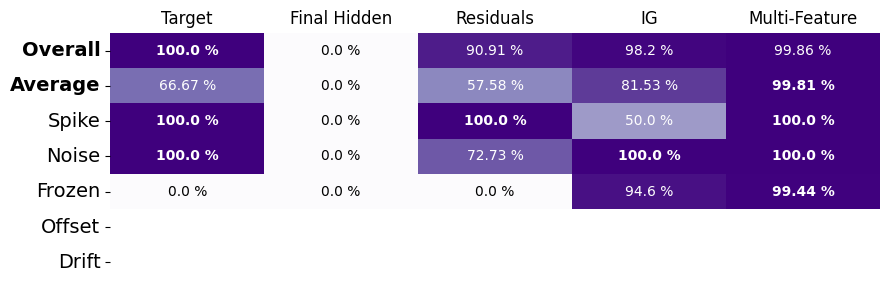

In [23]:
# row ordering
row_order = data_label_hue_order[1:] + ['Average', 'Overall']

# AUC
metric_df = pd.DataFrame(coverage_scores) * 100
# Calculate the average AUC as well
metric_df.loc['Average'] = metric_df.loc[data_label_hue_order[1:]].mean()
metric_df = metric_df.loc[row_order]
visualize_metric_matrix('coverage', metric_df, 'Purples', 2, suffix=" %", figsize=(9, 3), save_folder=save_folder)
visualize_metric_matrix('coverage', metric_df, 'Purples', 2, suffix=" %", figsize=(9, 3), save_folder=None)


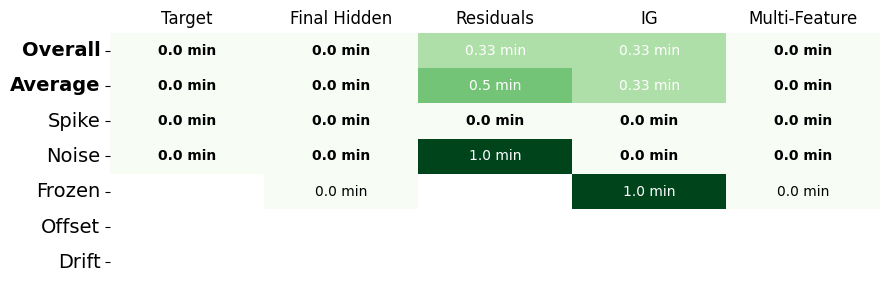

In [24]:
# row ordering
row_order = data_label_hue_order[1:] + ['Average', 'Overall']

# AUC
metric_df = pd.DataFrame(timing_start_scores)
# Calculate the average AUC as well
metric_df.loc['Average'] = metric_df.loc[data_label_hue_order[1:]].mean()
metric_df = metric_df.loc[row_order]
visualize_metric_matrix('timing_start', metric_df, 'Greens', 2, suffix=" min", high_best=False, figsize=(9, 3), save_folder=save_folder)
visualize_metric_matrix('timing_start', metric_df, 'Greens', 2, suffix=" min", high_best=False, figsize=(9, 3), save_folder=None)


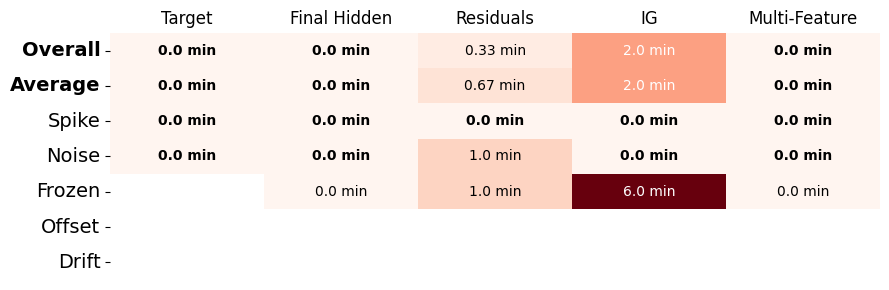

In [25]:
# row ordering
row_order = data_label_hue_order[1:] + ['Average', 'Overall']

metric_df = pd.DataFrame(timing_end_scores)
# Calculate the average AUC as well
metric_df.loc['Average'] = metric_df.loc[data_label_hue_order[1:]].mean()
metric_df = metric_df.loc[row_order]
visualize_metric_matrix('timing_end', metric_df, 'Reds', 2, suffix=" min", high_best=False, figsize=(9, 3), save_folder=save_folder)
visualize_metric_matrix('timing_end', metric_df, 'Reds', 2, suffix=" min", high_best=False, figsize=(9, 3), save_folder=None)


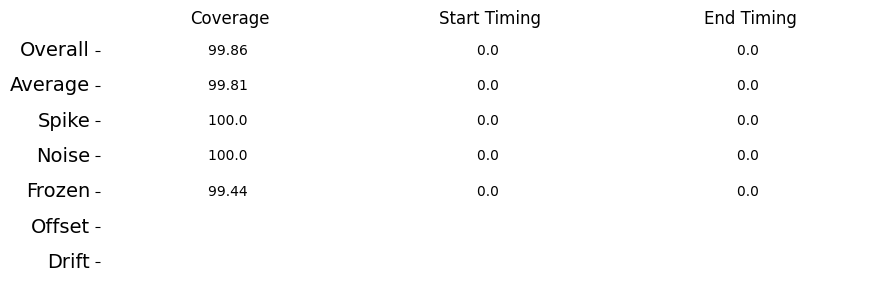

In [26]:
from matplotlib.colors import ListedColormap

method = "Multi-Feature"
score_dict = {
    'Coverage': coverage_scores[method],
    'Start Timing': timing_start_scores[method],
    'End Timing': timing_end_scores[method]
}


row_order = data_label_hue_order[1:] + ['Average', 'Overall']
metric_df = pd.DataFrame(score_dict)
metric_df["Coverage"] = metric_df["Coverage"] * 100
# Calculate the average AUC as well
metric_df.loc['Average'] = metric_df.loc[data_label_hue_order[1:]].mean()
metric_df = metric_df.loc[row_order]
white_cmap = ListedColormap(["white"])
visualize_metric_matrix(method, metric_df, white_cmap, 2, suffix=" ", high_best=None, top_n_bold=0, figsize=(9, 3), save_folder=save_folder)
visualize_metric_matrix(method, metric_df, white_cmap, 2, suffix=" ", high_best=None, top_n_bold=0, figsize=(9, 3), save_folder=None)

# Successful vs. Unsuccessful Detections

In [27]:
# Get the start and end of each anomaly
indices_of_ones = [index for index, value in enumerate(results['Actual']) if value == 1]
_, anomaly_start_end = find_unterrupted_sequences(indices_of_ones, 0)

In [28]:
data_label = results['Data Label']

# initialize dict
succ_unsucc = {}
succ_unsucc["Overall"] = {
    "Method": [],
    "Successful": [],
    "Unsuccessful": [],
}
for label in data_label_hue_order[::-1]:
    if label == 'Original':
        continue
    succ_unsucc[label] = {
        "Method": [],
        "Successful": [],
        "Unsuccessful": [],
    }


for i, key in enumerate(methods):
    coverage = get_coverage(results[key]['Predicted'], anomaly_start_end)
    succ_unsucc["Overall"]["Method"].append(key)
    succ_unsucc["Overall"]["Successful"].append(np.sum(np.array(coverage) > 0))
    succ_unsucc["Overall"]["Unsuccessful"].append(np.sum(np.array(coverage) == 0))
    
    # For each
    for label in data_label_hue_order[::-1]:
        if label == 'Original':
            continue
        else:
            # Anomaly filter
            mask = (np.array(data_label) == label)
        
        # Only for successful predictions
        start_end = [_anomaly_start_end[i] for i, (start, end) in enumerate(_anomaly_start_end) if mask[start]]
        coverage = get_coverage(results[key]['Predicted'], start_end)
        succ_unsucc[label]["Method"].append(key)
        succ_unsucc[label]["Successful"].append(np.sum(np.array(coverage) > 0))
        succ_unsucc[label]["Unsuccessful"].append(np.sum(np.array(coverage) == 0))
        
succ_unsucc.keys()

dict_keys(['Overall', 'Spike', 'Noise', 'Frozen', 'Offset', 'Drift'])

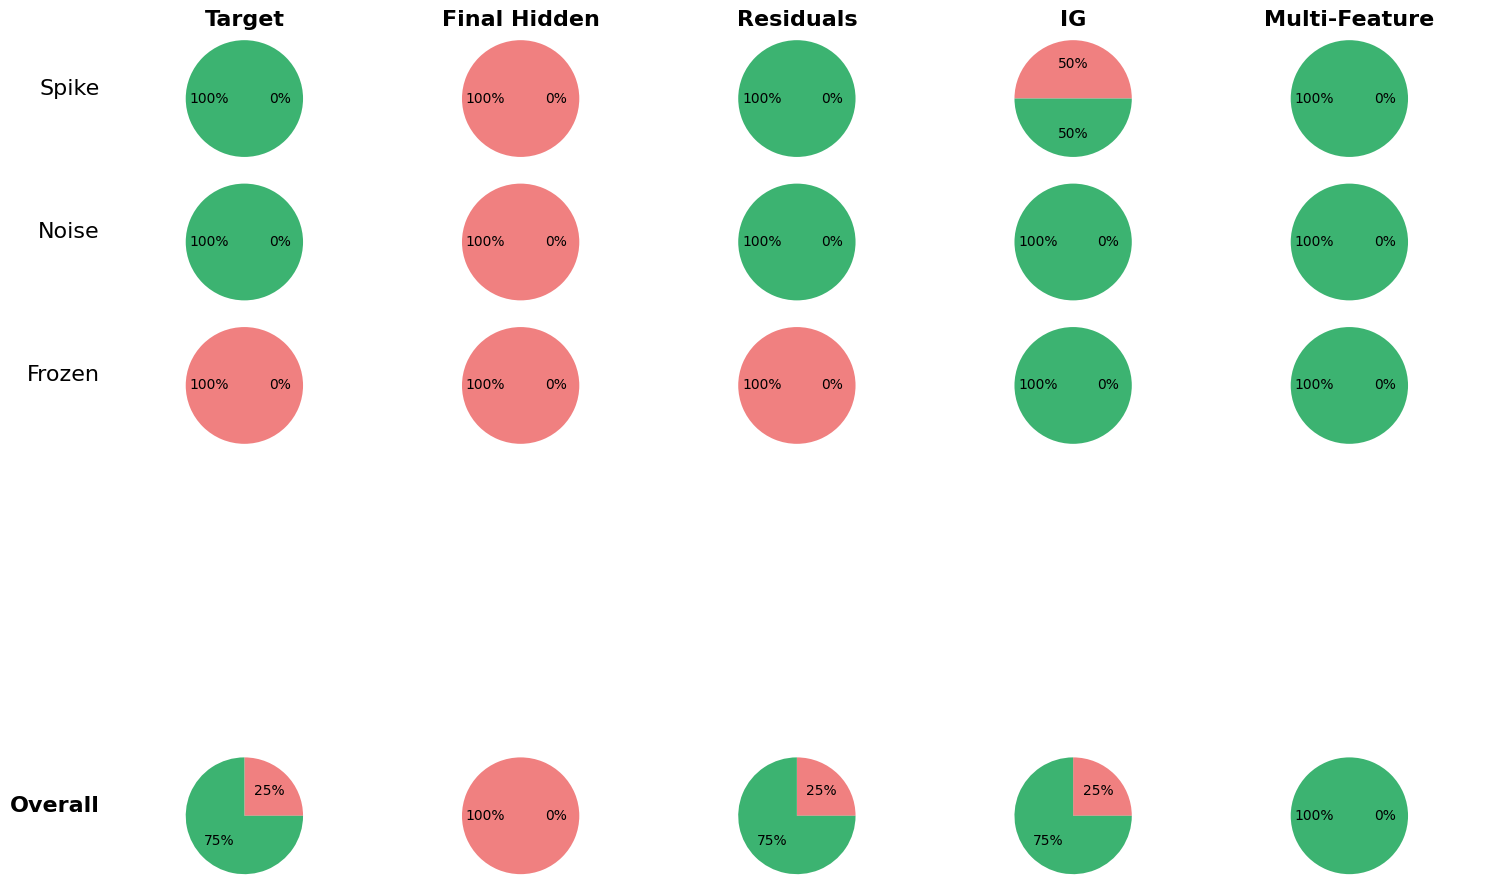

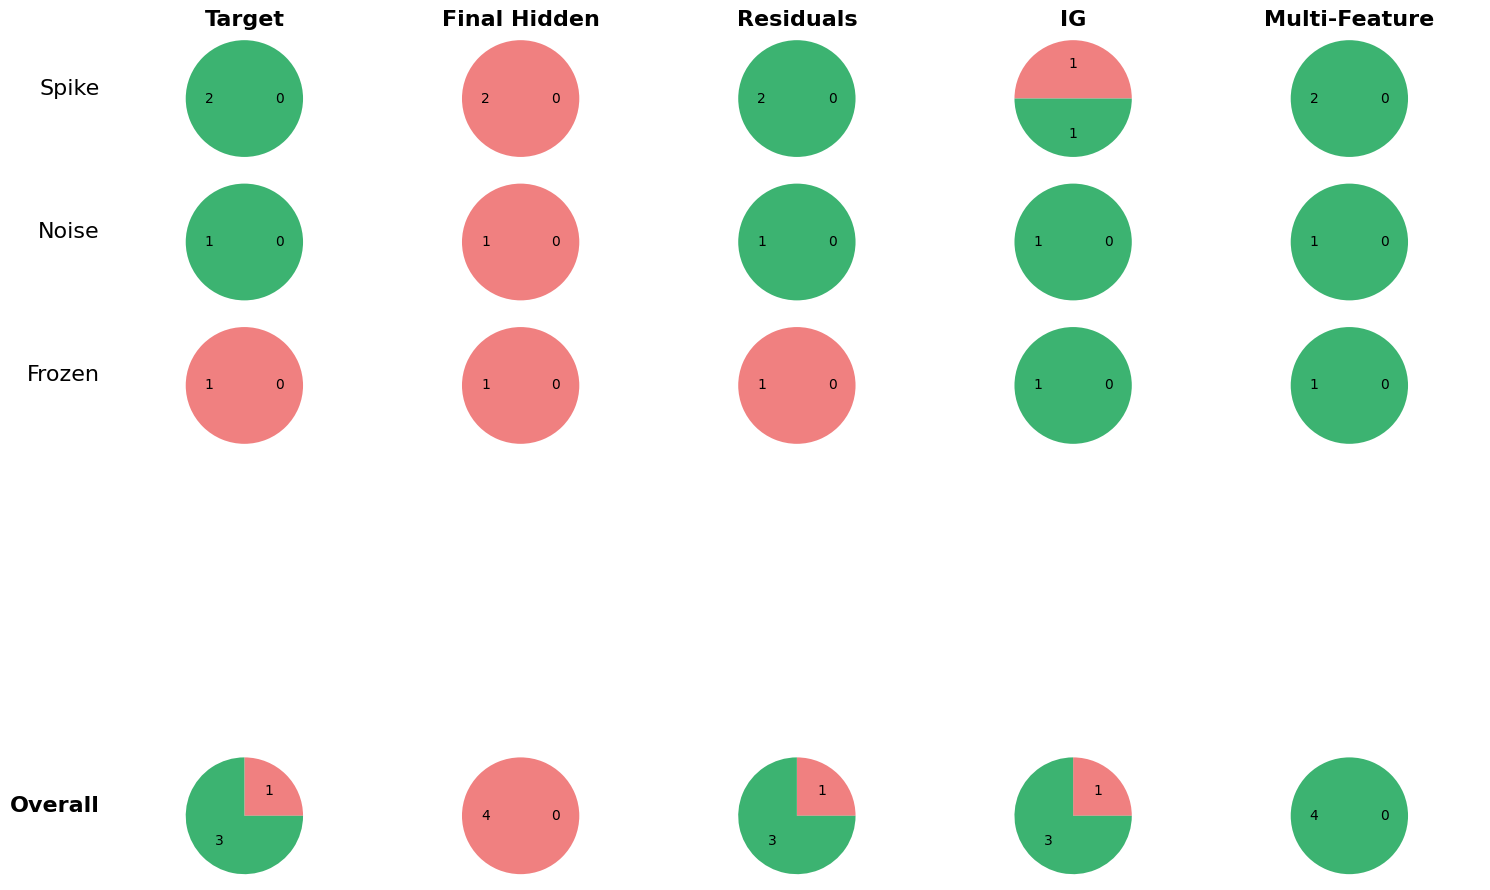

In [29]:

colors = {
    'Successful': 'mediumseagreen',
    'Unsuccessful': 'lightcoral'
}

to_show = ["percentage", "count"]
for show in to_show:
    # Create your figure
    fig, ax = plt.subplots(len(succ_unsucc), len(succ_unsucc["Overall"]["Method"]), figsize=(15, 9))

    # Iterate over the data
    iter_order = ['Spike', 'Noise', 'Frozen', 'Offset', 'Drift', 'Overall']
    for i, key in enumerate(iter_order):
        df = pd.DataFrame(succ_unsucc[key], columns=["Method", "Unsuccessful", "Successful"])
        df.set_index("Method", inplace=True)

        # ensure that the total sum is not zero
        if df.sum().sum() == 0:
            # set empty plot
            for j, method in enumerate(df.index):
                ax[i, j].axis('off')
            continue


        # Loop over each method and plot a pie chart
        for j, method in enumerate(df.index):
            # Get the data (Unsuccessful, Successful)
            data = [df.loc[method, 'Unsuccessful'], df.loc[method, 'Successful']]
            # Plot the pie chart
            ax[i, j].pie(data, 
                        #labels=['Unsuccessful', 'Successful'], 
                        # show count
                        autopct=lambda p: '{:.0f}'.format(p * sum(data) / 100) if show=="count" else '{:.0f}%'.format(p),
                        startangle=0,
                        colors=[colors['Unsuccessful'], colors['Successful']])

            ax[i, j].axis('equal')  # Equal aspect ratio ensures the pie chart is circular

            if i == 0:
                ax[i, j].set_title(method, fontsize=16, fontweight='bold')
            if j == 0:  
                fontweight = "bold" if key == "Overall" else None
                ax[i, j].set_ylabel(key, fontsize=16, rotation=0, labelpad=10, ha='right', fontweight=fontweight)
                ax[i, j].yaxis.set_major_formatter(formatter)

        #break

    # Adjust layout for clear spacing
    plt.tight_layout()
    plt.savefig(save_folder / f'successful_unsuccessful_{show}.png')
    plt.show()
    plt.close()

# Intervals and coverage

In [30]:
intervals_count = {}
intervals_sizes = {}
intervals_decisions = {}


for i, key in enumerate(methods):

    # Get total intervals per method
    # Get the start and end of each anomaly
    indices_of_ones = [index for index, value in enumerate(results[key]['Predicted']) if value == 1]
    _, predicted_start_end = find_unterrupted_sequences(indices_of_ones, 0)
    total_predicted_intervals = len(predicted_start_end)
    predicted_intervals_sizes = [end - start + 1 for start, end in predicted_start_end] 
    predicted_decisions = [np.mean(results[key]['Decision Function'][start:end+1]) for start, end in predicted_start_end]

    
    # Get total intervals with some coverage
    # Filter so that only keep start_and if any value in predicted_start_end is also 1 or more in actual
    predicted_and_actual_start_end = [start_end for start_end in predicted_start_end if np.sum(results['Actual'][start_end[0]:start_end[1]+1]) > 0]
    total_intervals_with_coverage = len(predicted_and_actual_start_end)
    coverage_intervals_sizes = [end - start + 1 for start, end in predicted_and_actual_start_end]
    coverage_decisions = [np.mean(results[key]['Decision Function'][start:end+1]) for start, end in predicted_and_actual_start_end]


    # Get total intervals without any coverage
    total_intervals_without_coverage = total_predicted_intervals - total_intervals_with_coverage
    no_coverage_intervals_sizes = [end - start + 1 for start, end in predicted_start_end if (start, end) not in predicted_and_actual_start_end]
    no_coverage_decisions = [np.mean(results[key]['Decision Function'][start:end+1]) for start, end in predicted_start_end if (start, end) not in predicted_and_actual_start_end]

    # Store the results
    intervals_count[key] = {
        'Total Predicted Intervals': total_predicted_intervals,
        'Total Intervals without Coverage': total_intervals_without_coverage,
        'Total Intervals with Coverage': total_intervals_with_coverage,

    }
    intervals_sizes[key] = {
        'Predicted Intervals Sizes': [end - start + 1 for start, end in predicted_start_end],
        'No Coverage Intervals Sizes': [end - start + 1 for start, end in predicted_start_end if (start, end) not in predicted_and_actual_start_end],
        'Coverage Intervals Sizes': [end - start + 1 for start, end in predicted_and_actual_start_end],
    }

    intervals_decisions[key] = {
        'Predicted Decisions': predicted_decisions,
        'No Coverage Decisions': no_coverage_decisions,
        'Coverage Decisions': coverage_decisions,
    }



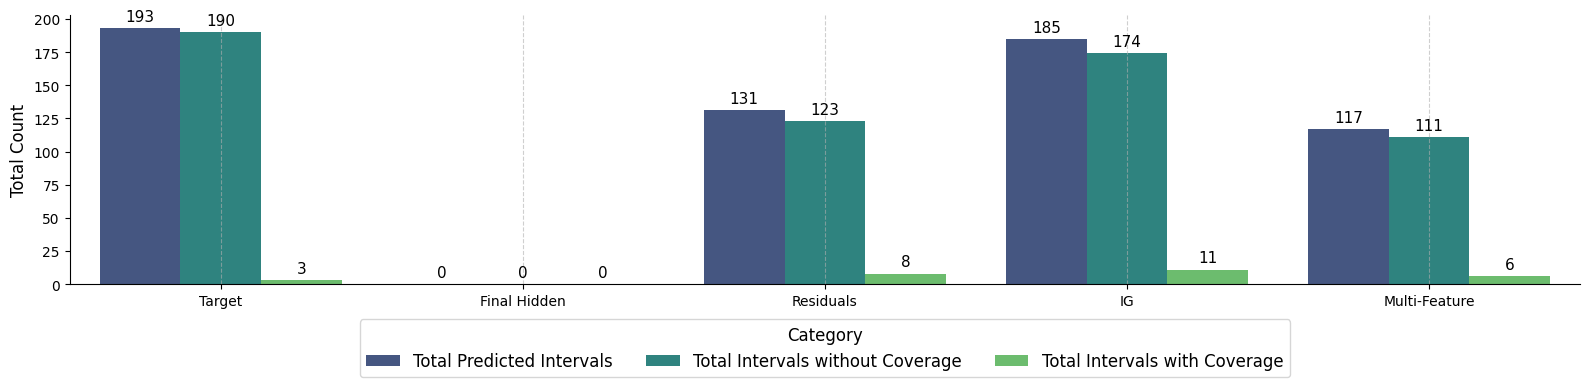

In [31]:
# Convert data to a DataFrame for easy visualization
df = pd.DataFrame.from_dict(intervals_count, orient="index").reset_index()
df = df.melt(id_vars="index", var_name="Category", value_name="Count")
df.rename(columns={"index": "Method"}, inplace=True)

# Plot
plt.figure(figsize=(16, 4))
ax = sns.barplot(data=df, x="Method", y="Count", hue="Category", palette="viridis")

# Add count labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt="%d", label_type="edge", fontsize=11, padding=3)


# Labels and title
plt.ylabel("Total Count", fontsize=12)
plt.xlabel(" ", fontsize=12)

plt.legend(title="Category", loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12, title_fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.6)

# remove spines on top and right
sns.despine()

plt.tight_layout()
plt.savefig(save_folder / 'intervals_count.png')
plt.show()
plt.close()

/tmp/ipykernel_503867/1272003263.py:24: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


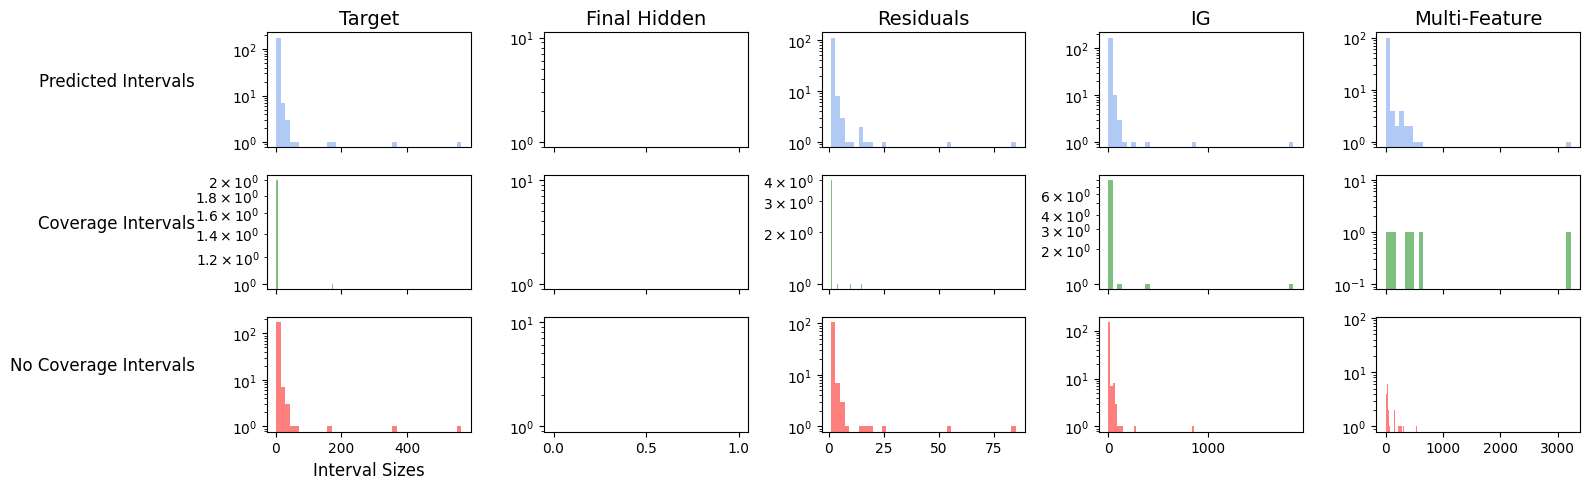

In [32]:
fig, axes = plt.subplots(3, len(methods), figsize=(16, 5), sharex="col")

for i, key in enumerate(methods):
    axes[0, i].hist(intervals_sizes[key]['Predicted Intervals Sizes'],
                    bins=40, color='cornflowerblue', alpha=0.5)
    axes[1, i].hist(intervals_sizes[key]['Coverage Intervals Sizes'], 
                    bins=40, color='green', alpha=0.5)
    axes[2, i].hist(intervals_sizes[key]['No Coverage Intervals Sizes'],
                    bins=40, color='red', alpha=0.5)
    axes[0, i].set_title(key, fontsize=14)
    
axes[0, 0].set_ylabel('Predicted Intervals',
                      fontsize=12, rotation=0, labelpad=0, ha='right')
axes[1, 0].set_ylabel('Coverage Intervals', 
                      fontsize=12, rotation=0, labelpad=0, ha='right')
axes[2, 0].set_ylabel('No Coverage Intervals',
                      fontsize=12, rotation=0, labelpad=0, ha='right')
axes[0, 0].yaxis.set_major_formatter(formatter)
axes[1, 0].yaxis.set_major_formatter(formatter)
axes[2, 0].yaxis.set_major_formatter(formatter)

# log scale the y axis
for ax in axes.flatten():
    ax.set_yscale('log')


axes[2, 0].set_xlabel('Interval Sizes', fontsize=12)
fig.align_ylabels()  # ensures all y-labels are properly aligned

plt.tight_layout()
plt.savefig(save_folder / 'interval_sizes.png')
plt.show()
plt.close()

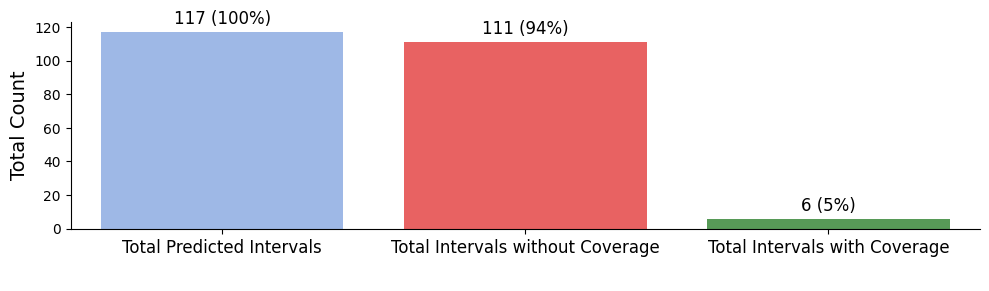

In [33]:
# create df based on intervals_count[method]
method = "Multi-Feature"
df = pd.DataFrame.from_dict(intervals_count[method], orient="index").reset_index()
# plot df
plt.figure(figsize=(10, 3))
# set color for each
ax = sns.barplot(data=df, x="index", y=0, 
                 hue="index", palette=["cornflowerblue", "red", "green"], alpha=0.7)

# set x labels larger
plt.xticks(fontsize=12)

# Add count labels on top of bars
for container in ax.containers:
    ax.bar_label(container,
                 labels=[f'{int(val)} ({int(val/intervals_count[method]["Total Predicted Intervals"]*100)}%)' for val in container.datavalues],
                 label_type="edge", fontsize=12, padding=3)

# Labels and title
plt.ylabel("Total Count", fontsize=14)
plt.xlabel(" ", fontsize=14)

# remove spines on top and right
sns.despine()

plt.tight_layout()
plt.savefig(save_folder / f'intervals_count_{method}.png', dpi=200)
plt.show()
plt.close()


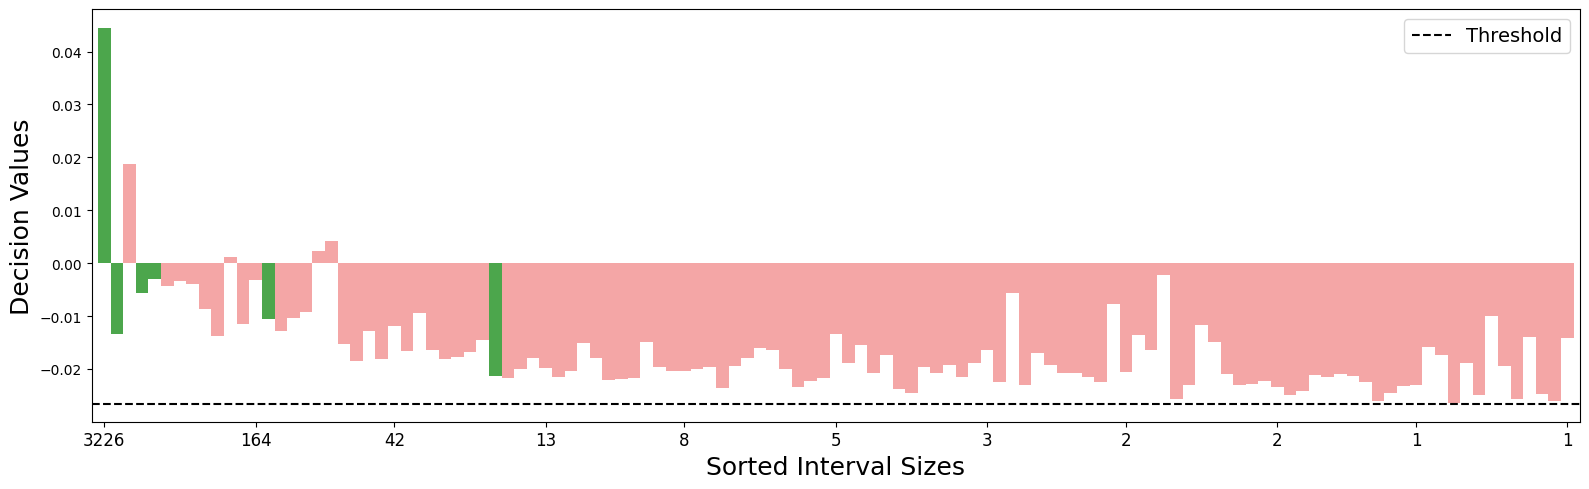

In [34]:

# plot the 
successes = [1] * len(intervals_decisions[method]['Coverage Decisions']) + [0] * len(intervals_decisions[method]['No Coverage Decisions'])
decisions = intervals_decisions[method]['Coverage Decisions'] + intervals_decisions[method]['No Coverage Decisions']
sizes = intervals_sizes[method]['Coverage Intervals Sizes'] + intervals_sizes[method]['No Coverage Intervals Sizes']

# Sort decisions and sizes by decision values in descending order
sorted_indices = np.argsort(sizes)[::-1]
sorted_decisions = np.array(decisions)[sorted_indices]
sorted_sizes = np.array(sizes)[sorted_indices]
sorted_successes = np.array(successes)[sorted_indices]

# Define colors based on successes
colors = ['green' if success == 1 else 'lightcoral' for success in sorted_successes]

# Plot
plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(sorted_sizes)), sorted_decisions, color=colors, alpha=0.7, width=1.0)
# show optimal threshold
plt.axhline(results[method]['Optimal Threshold'], color='black', linestyle='--', label='Threshold')

# set meaningful x ticks, every 10% of the data, and show size
xticks = np.linspace(0, len(sorted_sizes) - 1, 11)  # Avoid out-of-bounds index
xticks = np.round(xticks).astype(int)  # Convert to valid indices
xticklabels = [sorted_sizes[i] for i in xticks]  # Get corresponding values
plt.xticks(xticks, xticklabels, fontsize=12)

plt.xlim(-1, len(sorted_sizes))
plt.xlabel("Sorted Interval Sizes", fontsize=18)
plt.ylabel("Decision Values", fontsize=18)
plt.legend(loc='upper right', fontsize=14)
#plt.title("Decisions as a Function of Sizes")
plt.tight_layout()
plt.savefig(save_folder / f'decisions_sizes_{method}.png', dpi=200)
plt.show()
plt.close()

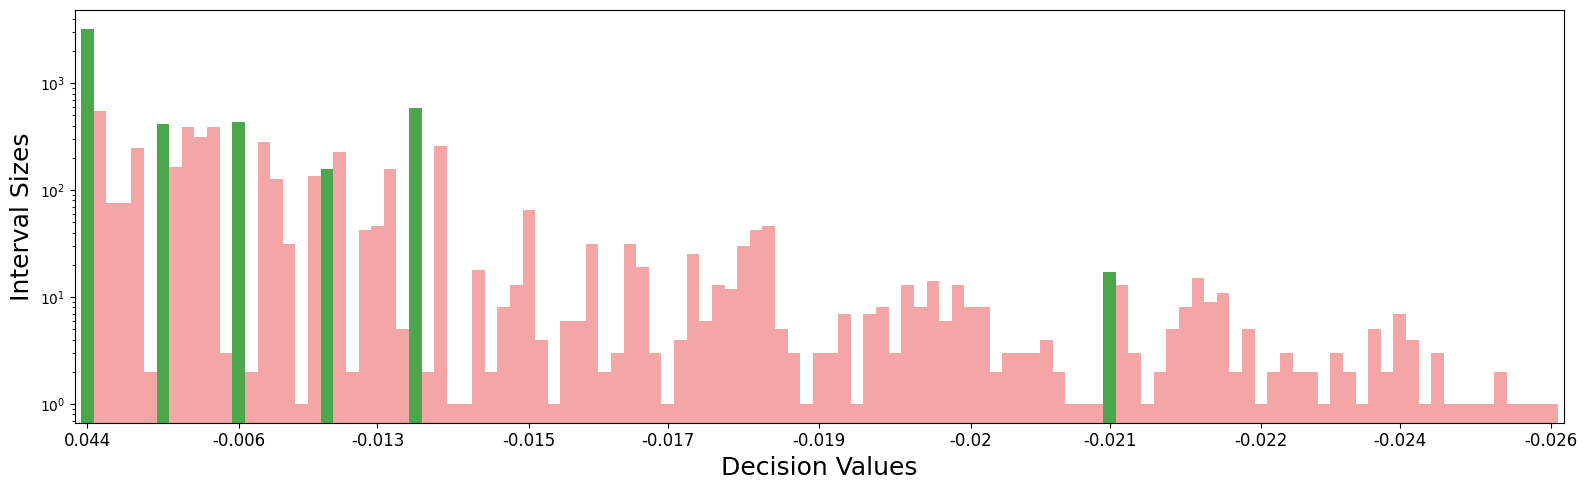

In [35]:

# plot the 
successes = [1] * len(intervals_decisions[method]['Coverage Decisions']) + [0] * len(intervals_decisions[method]['No Coverage Decisions'])
decisions = intervals_decisions[method]['Coverage Decisions'] + intervals_decisions[method]['No Coverage Decisions']
sizes = intervals_sizes[method]['Coverage Intervals Sizes'] + intervals_sizes[method]['No Coverage Intervals Sizes']

# Sort decisions and sizes by decision values in descending order
sorted_indices = np.argsort(decisions)[::-1]
sorted_decisions = np.array(decisions)[sorted_indices]
sorted_sizes = np.array(sizes)[sorted_indices]
sorted_successes = np.array(successes)[sorted_indices]

# Define colors based on successes
colors = ['green' if success == 1 else 'lightcoral' for success in sorted_successes]

# Plot
plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(sorted_decisions)), sorted_sizes, color=colors, alpha=0.7, width=1.0)
# log scale y axis
plt.yscale('log')
# plot the optimal threshold
optimal_threshold = results[method]['Optimal Threshold']
# vertical line
#plt.axvline(x=optimal_threshold, color='black', linestyle='--', label='Threshold')
# set meaningful x ticks, every 10% of the data, and show size
xticks = np.linspace(0, len(sorted_decisions) - 1, 11)  # Avoid out-of-bounds index
xticks = np.round(xticks).astype(int)  # Convert to valid indices
xticklabels = [np.round(sorted_decisions[i], 3) for i in xticks]  # Get corresponding values
plt.xticks(xticks, xticklabels, fontsize=12)

plt.xlim(-1, len(sorted_decisions))
plt.ylabel("Interval Sizes", fontsize=18)
plt.xlabel("Decision Values", fontsize=18)
#plt.title("Decisions as a Function of Sizes")
plt.tight_layout()
plt.savefig(save_folder / f'sizes_decisions_{method}.png', dpi=200)
plt.show()
plt.close()


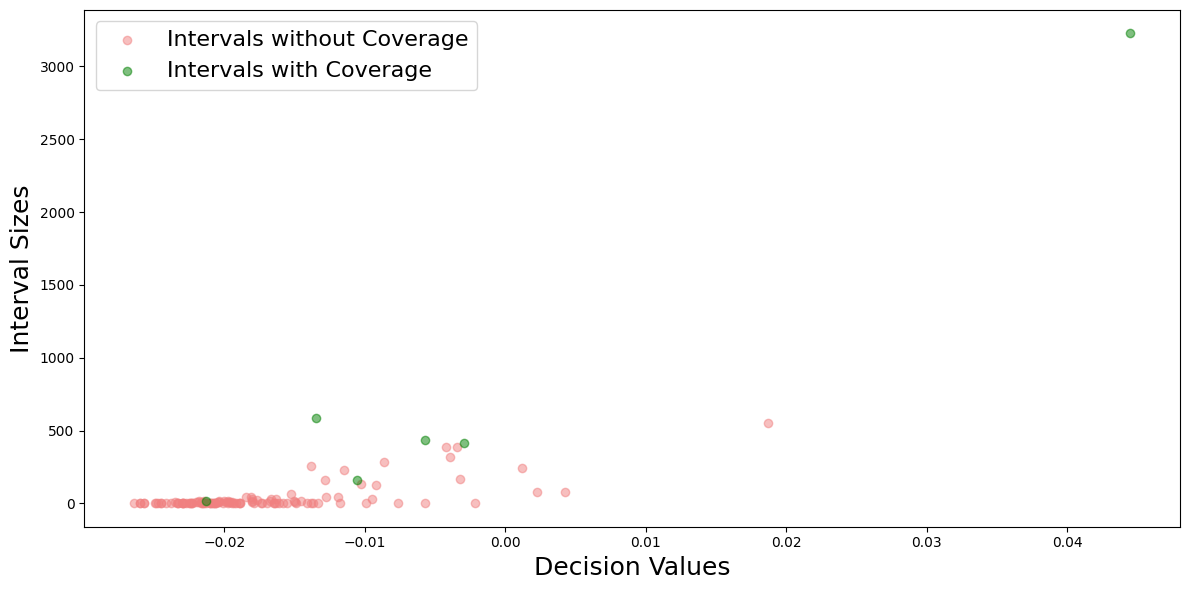

In [36]:

successful_desc = intervals_decisions[method]['Coverage Decisions']
successful_sizes = intervals_sizes[method]['Coverage Intervals Sizes']

unsuccessful_desc = intervals_decisions[method]['No Coverage Decisions']
unsuccessful_sizes = intervals_sizes[method]['No Coverage Intervals Sizes']


# plot scatter of unsuccessful then successful
plt.figure(figsize=(12, 6))
plt.scatter(unsuccessful_desc, unsuccessful_sizes, color='lightcoral', alpha=0.5, label='Intervals without Coverage')
plt.scatter(successful_desc, successful_sizes, color='green', alpha=0.5, label='Intervals with Coverage')

plt.ylabel("Interval Sizes", fontsize=18)
plt.xlabel("Decision Values", fontsize=18)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(save_folder / f'decisions_sizes_scatter_{method}.png', dpi=200)
plt.show()
plt.close()



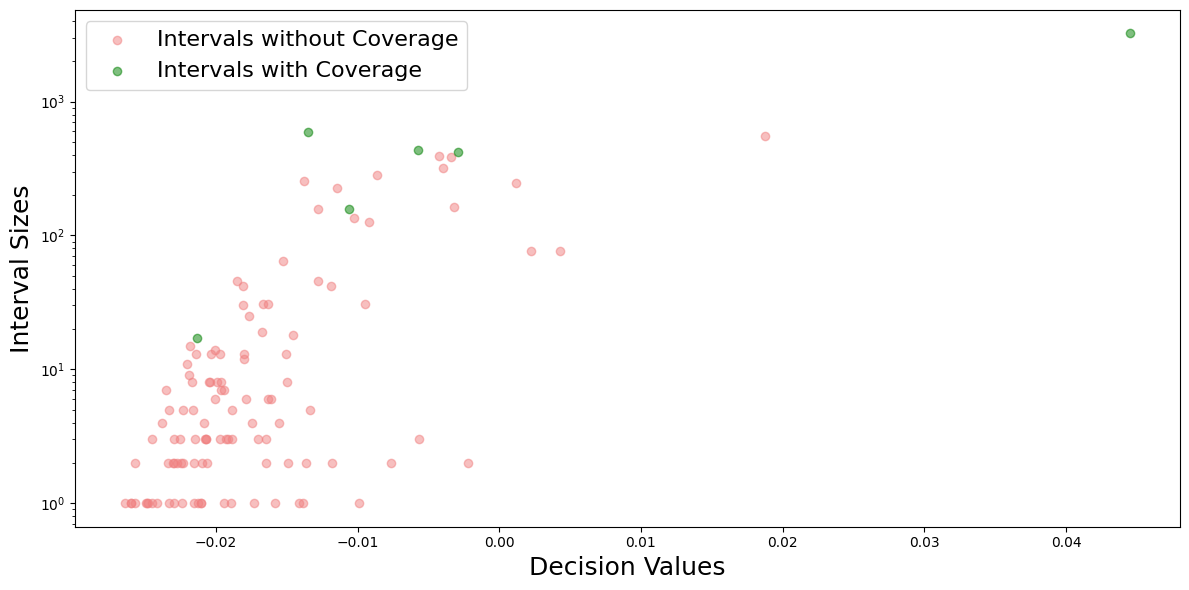

In [37]:

successful_desc = intervals_decisions[method]['Coverage Decisions']
successful_sizes = intervals_sizes[method]['Coverage Intervals Sizes']

unsuccessful_desc = intervals_decisions[method]['No Coverage Decisions']
unsuccessful_sizes = intervals_sizes[method]['No Coverage Intervals Sizes']


# plot scatter of unsuccessful then successful
plt.figure(figsize=(12, 6))
plt.scatter(unsuccessful_desc, unsuccessful_sizes, color='lightcoral', alpha=0.5, label='Intervals without Coverage')
plt.scatter(successful_desc, successful_sizes, color='green', alpha=0.5, label='Intervals with Coverage')

# log scale the y axis
plt.yscale('log')

plt.ylabel("Interval Sizes", fontsize=18)
plt.xlabel("Decision Values", fontsize=18)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(save_folder / f'decisions_sizes_scatter_v2_{method}.png', dpi=200)
plt.show()
plt.close()



# Binned Anomaly Intervals

In [38]:
from scipy.interpolate import interp1d

def get_decision_values(results, key, start_end, n_bins=10):

    # Create a fixed number of bins
    normalized_x = np.linspace(0, 1, n_bins)

    # Iterate through each 
    decision_values = []
    for start, end in start_end:
        # extract the decision function values
        decision_segment = results[key]['Decision Function'][start:end+1]

        if len(decision_segment) == 1:
            # If there's only one value, repeat it for all bins
            normalized_decision_values = np.full(n_bins, decision_segment[0])
        else:
            # Original x-coordinates (normalized from 0 to 1)
            original_x = np.linspace(0, 1, len(decision_segment))
            
            # Interpolation function
            interp_func = interp1d(original_x, decision_segment, kind='linear', bounds_error=False, fill_value="extrapolate")
            
            # Resample to fixed 10 points
            normalized_decision_values = interp_func(normalized_x)
        
        decision_values.append(normalized_decision_values)

    return np.array(decision_values)

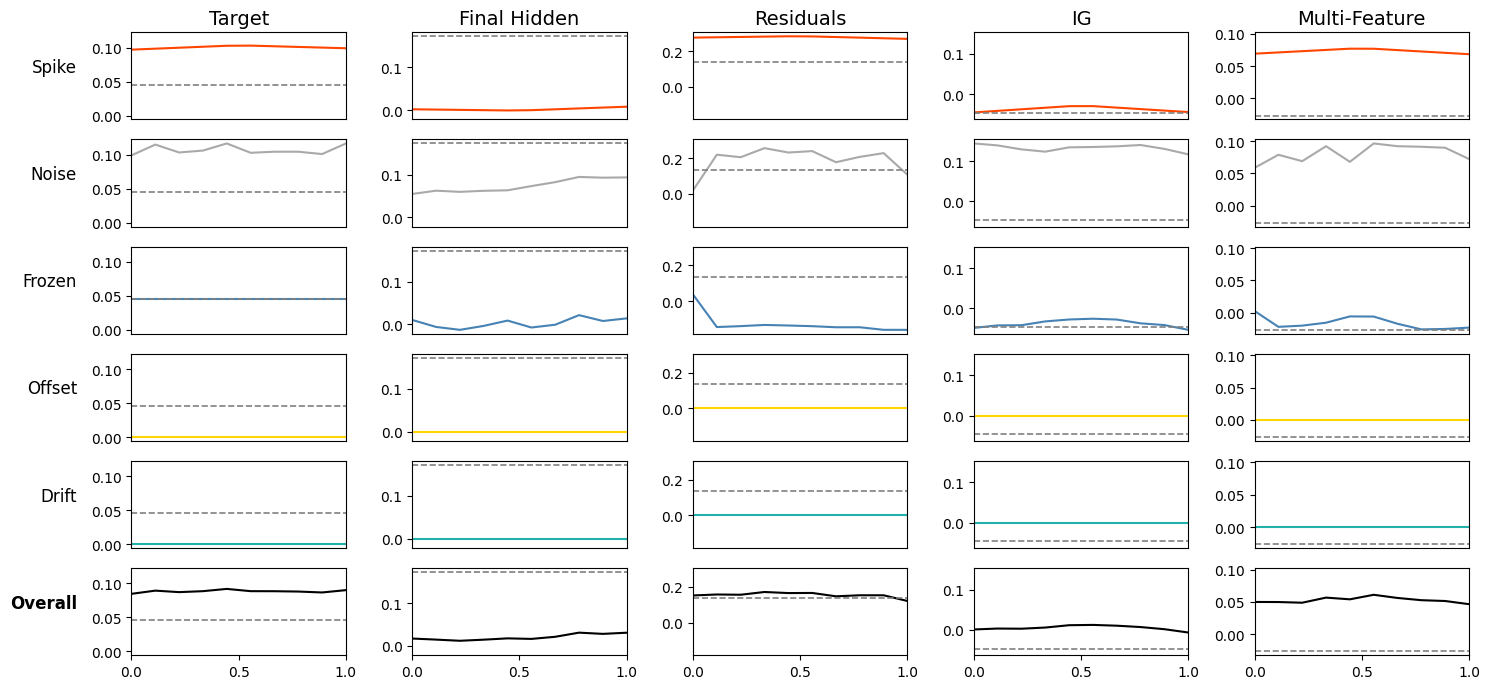

In [39]:
fig, axes = plt.subplots(len(data_label_hue_order), len(methods), figsize=(15, 7), sharey="col")

n_bins = 10
normalized_x = np.linspace(0, 1, n_bins)  # Create normalized positions

binned_decision_values = {}
start_times = {}
# For each method
for i, key in enumerate(methods):
    data_label = results['Data Label']
    binned_decision_values[key] = {}
    start_times[key] = {}
    # For each
    j=0
    for label in data_label_hue_order[::-1]:
        if label == 'Original':
            #continue
            # jsut use this to compute the overall
            label = "Overall"
            mask = np.array(data_label) != 'Original'
            color = 'black'
        else:
            # Anomaly filter
            mask = (np.array(data_label) == label)
            color = data_label_hue_map[label]
        
        # filter for starts based on the starts in _anomaly_start_end and mask
        start_end = [_anomaly_start_end[i] for i, (start, end) in enumerate(_anomaly_start_end) if mask[start]] # only those with coverage

        # Get the decision values
        decision_values = get_decision_values(results, key, start_end, n_bins)
        binned_decision_values[key][label] = decision_values
        # Store the start times
        start_times[key][label] = [results["Starttime"][start] for start, _ in start_end]

        # Average the decision values
        average_decision_values = np.mean(decision_values, axis=0) if len(decision_values) > 0 else np.zeros(n_bins)
        # Plot the average decision values as a line
        axes[j, i].plot(normalized_x, average_decision_values, label=label, color=color)
        threshold = results[key]["Optimal Threshold"]
        axes[j, i].axhline(threshold, color='grey', linestyle='--', label='Threshold', linewidth=1.2)
        axes[j, i].set_xlim([0, 1])
        axes[j, i].set_xticks([])
        #axes[j, i].set_yticks([])
        if j == 0:
            axes[j, i].set_title(key, fontsize=14)
        if i == 0:
            fontweight = 'bold' if label == 'Overall' else 'normal' 
            axes[j, i].set_ylabel(label, fontsize=12, rotation=0, labelpad=10, ha='right', fontweight=fontweight)
            axes[j, i].yaxis.set_major_formatter(formatter)
        j+=1
    
    axes[j-1, i].set_xticks([0, 0.5, 1])



plt.tight_layout()
plt.savefig(save_folder / 'binned_anomaly_intervals.png')
plt.show()
plt.close()


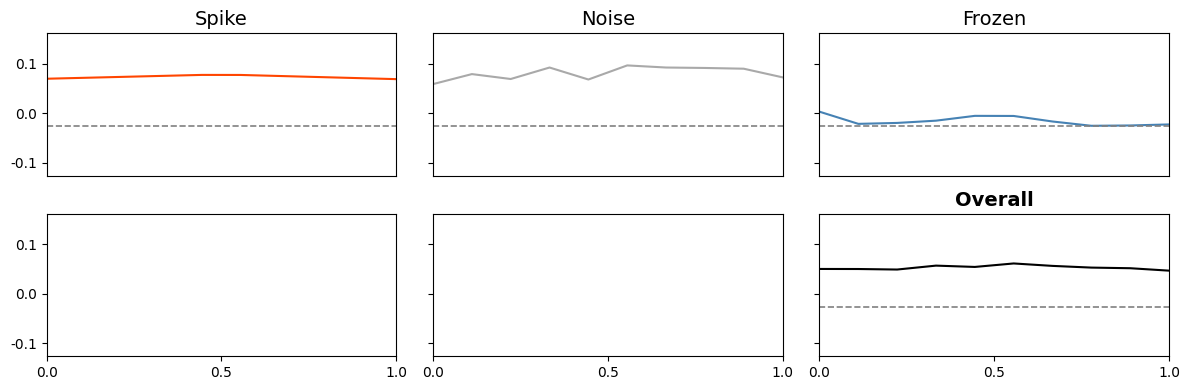

In [40]:
method = "Multi-Feature"


fig, axes = plt.subplots(2, 3, figsize=(12, 4), sharey=True)

axes = axes.flatten()

formatter = ticker.FuncFormatter(lambda x, _: f'{x:.3}')

n_bins = 10
normalized_x = np.linspace(0, 1, n_bins)  # Create normalized positions

# Visualize the binned_decision_values[method]
for j, label in enumerate(data_label_hue_order[::-1]):
    if label == 'Original':
        label = "Overall"
        color = 'black'
    else:
        # Anomaly filter
        color = data_label_hue_map[label]
        #color = "cornflowerblue"
    
    # extract the decision function values
    # check if empty
    if label not in binned_decision_values[method]:
        continue
    elif len(binned_decision_values[method][label]) == 0:
        continue
    else:
        average_decision_values = binned_decision_values[method][label].mean(axis=0)

    # Plot the average decision values as a line
    axes[j].plot(normalized_x, average_decision_values, color=color, label="Avg. Decision Values") # label=label,
    threshold = results[method]["Optimal Threshold"]
    axes[j].axhline(threshold, color='grey', linestyle='--', label='Threshold', linewidth=1.2)
    axes[j].set_xlim([0, 1])
    # set ylim
    axes[j].set_ylim([threshold-0.1, max(average_decision_values) + 0.1])
    axes[j].set_xticks([])
    fontweight = 'bold' if label == 'Overall' else 'normal' 
    #axes[j].set_ylabel(label, fontsize=12, rotation=0, labelpad=10, ha='right', fontweight=fontweight)
    axes[j].set_title(label, fontsize=14, fontweight=fontweight)
    axes[j].yaxis.set_major_formatter(formatter)

# for last three, set xticks
for j in range(3):
    axes[j+3].set_xticks([0, 0.5, 1])


# set legend at bottom flattened
#axes[4].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=12)


plt.tight_layout()
plt.savefig(save_folder / f'binned_anomaly_intervals_{method}.png', dpi=200)
plt.show()
plt.close()


# Qualitative examples

For:
- Most accurate detection
- Least accurate detection
- Most certain non-anomaly


In [41]:
# ignore sigma 3 and overall
#methods = methods[:-1]
print(methods)
_anomalies = data_label_hue_order[1:][::-1]
print(_anomalies)

# Get the start and end of each anomaly
indices_of_ones = [index for index, value in enumerate(results['Actual']) if value == 1]
_, anomaly_start_end = find_unterrupted_sequences(indices_of_ones, 0)


binned_decision_values = {}
anomaly_intervals = {}
# For each method
for i, key in enumerate(methods):
    data_label = results['Data Label']
    binned_decision_values[key] = {}
    # For each
    for label in _anomalies:
        if label == 'Original':
            continue
        else:
            # Anomaly filter
            mask = np.array(data_label) == label
        
        # filter for starts based on the starts in _anomaly_start_end and mask
        start_end = [anomaly_start_end[i] for i, (start, end) in enumerate(anomaly_start_end) if mask[start]] # only this anomaly
        # If empty then continue
        if len(start_end) == 0:
            continue

        # Get the decision values
        decision_values = get_decision_values(results, key, start_end, n_bins)
        binned_decision_values[key][label] = decision_values
        # Store the start times
        if i == 0: # 
            anomaly_intervals[label] = {
                "Starts": [results["Starttime"][start] for start, _ in start_end],
                "Ends": [results["Starttime"][end] for _, end in start_end],
                # and in index
                "start_indices": [start for start, _ in start_end],
                "end_indices": [end for _, end in start_end]
            }
            #[results["Starttime"][start] for start, _ in start_end]

['Target', 'Final Hidden', 'Residuals', 'IG', 'Multi-Feature']
['Spike', 'Noise', 'Frozen', 'Offset', 'Drift']


In [42]:
binned_decision_values = {}
start_times = {}
# For each method
for i, key in enumerate(methods):
    data_label = results['Data Label']
    binned_decision_values[key] = {}
    start_times[key] = {}
    # For each
    j=0
    for label in data_label_hue_order[::-1]:
        if label == 'Original':
            #continue
            # jsut use this to compute the overall
            label = "Overall"
            mask = np.array(data_label) != 'Original'
            color = 'black'
        else:
            # Anomaly filter
            mask = (np.array(data_label) == label)
            color = data_label_hue_map[label]
        
        # filter for starts based on the starts in _anomaly_start_end and mask
        start_end = [_anomaly_start_end[i] for i, (start, end) in enumerate(_anomaly_start_end) if mask[start]]

        # Get the decision values
        decision_values = get_decision_values(results, key, start_end, n_bins)
        binned_decision_values[key][label] = decision_values
        

In [43]:
# get filter anomalies in case of empty
_anomalies = [label for label in _anomalies if label in binned_decision_values[key]]
print(_anomalies)


# Ensure equal count per anomaly
for anomaly in _anomalies:
    counts = np.unique([len(binned_decision_values[method][anomaly]) for method in methods])
    assert len(counts) == 1, f"Counts are not equal for {anomaly}: {counts}"



# using only this method
method = "Multi-Feature" 

['Spike', 'Noise', 'Frozen', 'Offset', 'Drift']


In [44]:
detections = {
    'Most Accurate': {},
    'Least Accurate': {},
    'Overall Most Accurate': {},
    'Overall Least Accurate': {},
    'Most Certain Non-Anomaly': {},
}

all_most_accurate = []
all_least_accurate = []

for anomaly in _anomalies:
    n_anomalies = len(binned_decision_values[method][anomaly])
    if n_anomalies == 0:
        continue

    decision_values = [
        np.mean(binned_decision_values[method][anomaly][i])
        for i in range(n_anomalies)
    ]
    coverage_values = [
        np.mean(binned_decision_values[method][anomaly][i] > results[method]['Optimal Threshold'])
        for i in range(n_anomalies)
    ]

    closest_stop_before_start = []
    closest_stop_after_end = []
    predicted = results[method]['Predicted']

    for i, (start, stop) in enumerate(zip(anomaly_intervals[anomaly]["start_indices"], anomaly_intervals[anomaly]["end_indices"])):
        if stop - start == 0:
            closest_stop_before_start.append(np.inf)
            closest_stop_after_end.append(np.inf)
            continue

        # Find closest 0 before start
        idxs_before = np.argwhere(predicted[:start][::-1] == 0)
        closest_stop_before_start.append(idxs_before[0][0] if idxs_before.size > 0 else np.inf)

        # Find closest 0 after stop
        idxs_after = np.argwhere(predicted[stop:] == 0)
        closest_stop_after_end.append(idxs_after[0][0] if idxs_after.size > 0 else np.inf)

    # Sum closest stop distances
    closest_stop = np.array(closest_stop_before_start) + np.array(closest_stop_after_end)

    # Sort indices based on first highest coverage, then closest stop
    sorted_indices = sorted(
        range(n_anomalies), key=lambda i: (-coverage_values[i], closest_stop[i])
    )

    most_accurate = sorted_indices[0]
    least_accurate = sorted_indices[-1]

    most_accurate_data = {
        'Anomaly': anomaly,
        'Avg. Decision Values': decision_values[most_accurate],
        'Avg. Coverage Values': coverage_values[most_accurate],
        'Closest Stop Before Start': closest_stop_before_start[most_accurate],
        'Closest Stop After End': closest_stop_after_end[most_accurate],
        'Start Time': anomaly_intervals[anomaly]["Starts"][most_accurate],
        'End Time': anomaly_intervals[anomaly]["Ends"][most_accurate]
    }

    least_accurate_data = {
        'Anomaly': anomaly,
        'Avg. Decision Values': decision_values[least_accurate],
        'Avg. Coverage Values': coverage_values[least_accurate],
        'Closest Stop Before Start': closest_stop_before_start[least_accurate],
        'Closest Stop After End': closest_stop_after_end[least_accurate],
        'Start Time': anomaly_intervals[anomaly]["Starts"][least_accurate],
        'End Time': anomaly_intervals[anomaly]["Ends"][least_accurate]
    }

    detections['Most Accurate'][anomaly] = most_accurate_data
    detections['Least Accurate'][anomaly] = least_accurate_data

    all_most_accurate.append(most_accurate_data)
    all_least_accurate.append(least_accurate_data)

# Find the overall most and least accurate based on coverage values
n_top = 3

# Sort the lists based on 'Avg. Decision Values'
sorted_most_accurate = sorted(all_most_accurate, key=lambda x: x['Avg. Decision Values'], reverse=True)
sorted_least_accurate = sorted(all_least_accurate, key=lambda x: x['Avg. Decision Values'])

detections['Overall Most Accurate'] = {f'Top {i+1}': sorted_most_accurate[i] for i in range(min(n_top, len(sorted_most_accurate)))}
detections['Overall Least Accurate'] = {f'Top {i+1}': sorted_least_accurate[i] for i in range(min(n_top, len(sorted_least_accurate)))}

# detections['Overall Most Accurate']['Top 1'] = max(all_most_accurate, key=lambda x: x['Avg. Decision Values'], default=None)
# detections['Overall Least Accurate']['Top 1'] = min(all_least_accurate, key=lambda x: x['Avg. Decision Values'], default=None)


In [45]:

# Get the most certain non-anomaly
# using same only this method
n_top = 5

# Get the start and end of each anomaly
indices_of_ones = [index for index, value in enumerate(results['Actual']) if value == 1]
_, anomaly_start_end = find_unterrupted_sequences(indices_of_ones, 0)

# Get the start and end of each anomaly
indices_of_ones = [index for index, value in enumerate(results[method]["Predicted"].astype(int)) if value == 1]
_, predicted_start_end = find_unterrupted_sequences(indices_of_ones, 0)

decision_values = []
start_end = []
for start, end in predicted_start_end:
    # # Ensure not part of an anomaly
    # if np.any([start <= anomaly[0] <= end for anomaly in anomaly_start_end]):
    #     continue
    def intervals_overlap(start1, end1, start2, end2):
        return not (end1 < start2 or end2 < start1)

    if np.any([intervals_overlap(start, end, anomaly[0], anomaly[1]) for anomaly in anomaly_start_end]):
        continue
    # Get the decision values
    decision_values.append(results[method]['Decision Function'][start:end+1].mean())
    start_end.append((start, end))

# select n top based on selected to min 
n_possible = len(decision_values)
n_top = min(n_top, n_possible)

sorted_indices = np.argsort(decision_values)[::-1]  # Sort indices in descending order

for top in range(n_top):
    most_certain_non_anomaly = sorted_indices[top]
    #most_certain_non_anomaly = np.argsort(decision_values)[-(top+1)]
    detections['Most Certain Non-Anomaly'][f'Top {top+1}'] = {
        'Avg. Decision Values': decision_values[most_certain_non_anomaly],
        'Start Time': results['Starttime'][start_end[most_certain_non_anomaly][0]],
        'End Time': results['Starttime'][start_end[most_certain_non_anomaly][1]]
    }



In [46]:
detection_theme = "Most Accurate"

detection_type = "Noise"

In [47]:
# ### Difference vs. decision function plot


from fault_management_uds.get_detection import load_model_outputs
from fault_management_uds.data.dataset import load_data, load_dataframe_from_HDF5
from fault_management_uds.plots import visualize_error_span, set_meaningful_xticks

from fault_management_uds.data.load import import_metadata

metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')


# Load the model outputs
outputs, column_2_idx = load_model_outputs(anomalous_path / data_type)
# set all the column 2 idx keys to lower
#column_2_idx = {key.lower(): value for key, value in column_2_idx.items()}

# create the multi-feature indices
all_feature_indices = []
for feature in methods[:-1]:
    all_feature_indices.extend(column_2_idx[feature.lower()])
# add to column_2_idx
column_2_idx['multi-feature'] = all_feature_indices


detections['Most Accurate'].keys()

Outputs: (9213, 90)
Column 2 idx: ['Starttime', 'Valid index', 'Data label', 'Target', 'Residual', 'Prediction', 'Final hidden', 'IG', 'Residuals']
Outputs after features: (9212, 90)


dict_keys(['Spike', 'Noise', 'Frozen'])

In [48]:

# create a save folder
_save_folder = save_folder / detection_theme / detection_type
os.makedirs(_save_folder, exist_ok=True)

# Extract
detection = detections[detection_theme][detection_type]
_starttime = detection['Start Time']
starttime = pd.to_datetime(_starttime)
_endtime = detection['End Time']
endtime = pd.to_datetime(_endtime)

# Extract from the model outputs
starttimes = pd.to_datetime(outputs[:, column_2_idx['starttime']].flatten())

# Identify start and end indices
_start_idx = np.where(starttimes == starttime)[0][0]
_end_idx = np.where(starttimes == endtime)[0][0]
#timestamps = pd.date_range(starttime, endtime, freq='1min')

In [49]:


# #### Visualize the actual time line

# Get the data to visualize anomaly
#go_back_forth = 30 # minutes
go_back_forth = 2*(_end_idx - _start_idx)

show_start = starttime - pd.Timedelta(minutes=go_back_forth)
show_end = endtime + pd.Timedelta(minutes=go_back_forth)            

# Identify start and end indices
start_idx = np.where(starttimes == show_start)[0][0]
end_idx = np.where(starttimes == show_end)[0][0]

show_timestamps = pd.date_range(start=show_start, end=show_end, freq='1min')
# create the indicator
indicator = np.zeros(len(show_timestamps))
mask = (show_timestamps >= starttime) & (show_timestamps <= endtime)
indicator[mask] = 1

# Extract the data
data = outputs[start_idx:end_idx+1, :]
polluted_data = pd.DataFrame(data[:, column_2_idx['target']], index=show_timestamps, columns=['value'])

# set show timestamps to the polluted data time stamps
show_timestamps = polluted_data.index



# Get the data
sensor_name = config['dataset_args']['endogenous_vars'][0]
true_data, _, _, _ = load_dataframe_from_HDF5(
    config['dataset_args']['data_file_path'], 
    #f"combined_data/{config['dataset_args']['data_group']}", 
    f"combined_data/clean", 
    #columns=config['dataset_args']['endogenous_vars'],
    columns=['5425', sensor_name],
    starttime=show_start, 
    endtime=show_end, 
    complete_range=True
)
true_data.rename(columns={config['dataset_args']['endogenous_vars'][0]: 'value'}, inplace=True)




unit = metadata[metadata['IdMeasurement'] == sensor_name]['UnitAlias'].values[0]



data_dict = {
    'original': true_data,
    '5425': true_data,
    'polluted': polluted_data,
    'start': show_start,
    'end': show_end,
    'indicator_dict': {
        'indicator': indicator,
        'colormap': {
            0: 'none',
            1: 'firebrick',
        }
    }
}

# create an indicator for the detection algorithm, based on the decision values and threshold
decision_values = results[method]['Decision Function'][start_idx:end_idx+1]
threshold = results[method]["Optimal Threshold"]

detection_indicator = np.zeros(len(decision_values))
detection_indicator[decision_values > threshold] = 1


indicator_dict = {
    'indicator': detection_indicator,
    'colormap': {
        0: 'none',
        1: 'firebrick',
    }
}

In [50]:

def visualize_rain(ax, title, data_dict, marker='o', linewidth=1):
    ax.set_title(title, fontsize=20)
    ### Visualize rain data
    rain_gauge = '5425'
    ax.plot(data_dict["original"][rain_gauge].index, data_dict["original"][rain_gauge],
        label=f'Rain gauge {rain_gauge}', color='darkblue',
        linewidth=linewidth, linestyle='-', 
        marker=marker, markersize=1, alpha=1)
    ax.set_ylabel('Rain (mm)')
    ax.legend(loc='upper right')
    ax.set_xticks([])
    # set y limits based on 0 and max wrt both
    ax.set_ylim(-0.5, data_dict["original"]['5425'].max()+1)
    ax.set_xlim(data_dict['start'], data_dict['end'])
    return ax

def visualize_injected_synthetics(ax, title, data_dict, unit, marker='o'):

    # visualize the sensor data; severities
    ax.set_title(title, fontsize=20)
    ax.plot(data_dict['original'].index, data_dict['original'].value, 
        label='Original data', color='grey', 
        linewidth=1, linestyle='-', 
        marker='', markersize=1, alpha=1)

    ax.plot(data_dict['polluted'].index, data_dict['polluted'].value, 
        label='Erroneous data', color='grey', 
        linewidth=2, linestyle='-', 
        marker=marker, markersize=2, alpha=1)
    # visualzie error span
    #ax = visualize_error_span(ax, data_dict['indicator_dict'], data_dict['start'], data_dict['end'], adjust='full-point')
    ax.set_xlim(data_dict['start'], data_dict['end'])
    ax.set_ylabel(unit)
    ax.set_xticks([])
    return ax



In [51]:
data_dict['start'], starttime

(Timestamp('2018-05-01 12:15:00'), Timestamp('2018-05-01 13:41:00'))

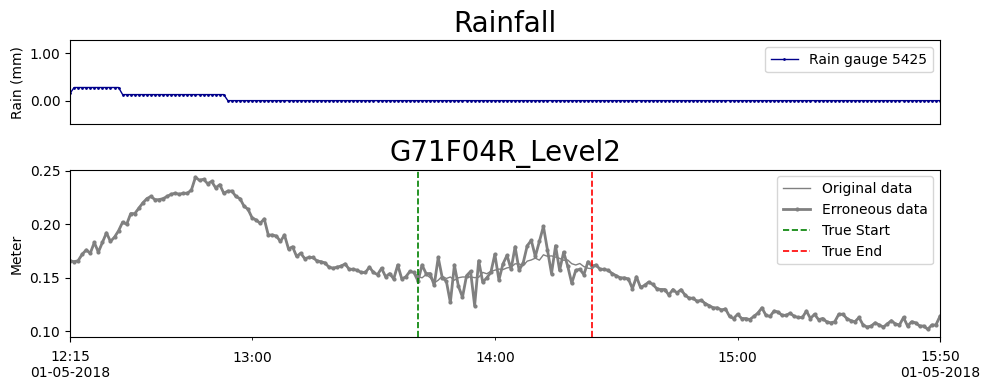

In [52]:
# Plot the time series
formatter = ticker.FormatStrFormatter('%.2f')  # Change to the desired format, e.g., '%.3f' for three decimal places

fig, axs = plt.subplots(2, 1, figsize=(10, 4), height_ratios=[1, 2])
axs[0] = visualize_rain(axs[0], 'Rainfall', data_dict)
axs[0].yaxis.set_major_formatter(formatter)
axs[1] = visualize_injected_synthetics(axs[1], sensor_name, data_dict, unit)

# true start and stop
axs[1].axvline(starttime, color='green', linestyle='--', linewidth=1.2, label='True Start')
axs[1].axvline(endtime, color='red', linestyle='--', linewidth=1.2, label='True End')

axs[1].yaxis.set_major_formatter(formatter)
axs[-1] = set_meaningful_xticks(axs[-1], data_dict['start'], data_dict['end'])
axs[1].legend()

plt.tight_layout()
plt.savefig(_save_folder / 'anomaly_visualization.png', dpi=150)
plt.show()
plt.close()



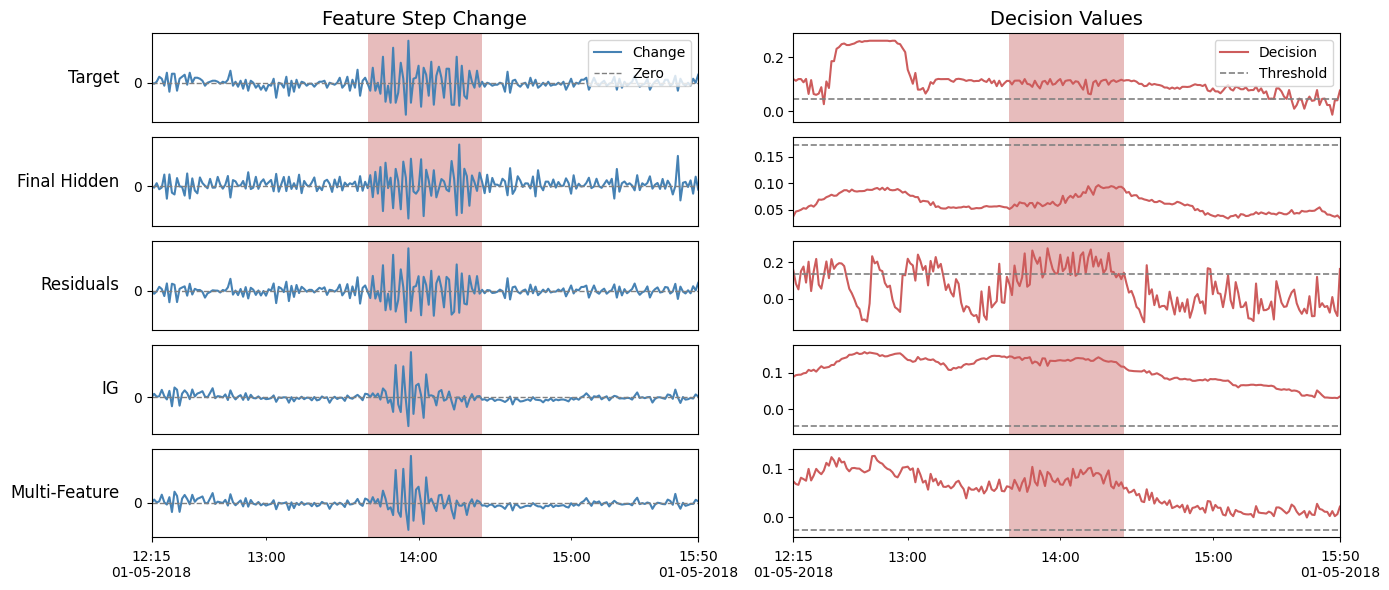

In [53]:

fig, axs = plt.subplots(len(methods), 2, figsize=(14, 6))

# Inside your plotting function/loop
formatter = ticker.FormatStrFormatter('%.0f')  # Change to the desired format, e.g., '%.3f' for three decimal places

# Extract from the model outputs
start_idx = np.where(starttimes == show_start)[0][0]
end_idx = np.where(starttimes == show_end)[0][0]
data = outputs[start_idx:end_idx+1, :]

for i, method in enumerate(methods):

    # add background error spand
    axs[i, 0] = visualize_error_span(axs[i, 0], data_dict['indicator_dict'], data_dict['start'], data_dict['end'], adjust='full-point')
    axs[i, 1] = visualize_error_span(axs[i, 1], data_dict['indicator_dict'], data_dict['start'], data_dict['end'], adjust='full-point')


    # Extract the features
    features = data[:, column_2_idx[method.lower()]]
    diff1 = np.diff(features, axis=0) # calculate the diff 1 across the observations
    mean_diff1 = np.mean(diff1, axis=1) # mean across the dimensions
    mean_diff1 = np.insert(mean_diff1, 0, 0) # add zero as first element
    # visualize the mean diff
    axs[i, 0].plot(show_timestamps, mean_diff1, color='steelblue', label='Change')
    axs[i, 0].axhline(0, color='grey', linestyle='--', linewidth=1, label='Zero')
    # formatting
    axs[i, 0].set_ylabel(method, fontsize=12, rotation=0, labelpad=10, ha='right', va='center')
    min_max_diff_div = (max(mean_diff1) - min(mean_diff1)) / 10
    axs[i, 0].set_ylim(mean_diff1.min()-min_max_diff_div, mean_diff1.max()+min_max_diff_div)
    axs[i, 0].set_yticks([0])
    axs[i, 0].yaxis.set_major_formatter(formatter)
    axs[i, 0].set_xlim(show_start, show_end)


    # Extract the decision values
    decision_values = results[method]['Decision Function'][start_idx:end_idx+1]
    # Plot the decision function
    axs[i, 1].plot(show_timestamps, decision_values, label='Decision', color='indianred')
    # get the optimal threshold
    threshold = results[method]["Optimal Threshold"]
    axs[i, 1].axhline(threshold, color='grey', linestyle='--', label='Threshold', linewidth=1.2)
    # formatting
    decision_values = np.insert(decision_values, 0, threshold) # add threshold as first element
    min_max_diff_div = (max(decision_values) - min(decision_values)) / 10
    axs[i, 1].set_ylim(decision_values.min()-min_max_diff_div, decision_values.max()+min_max_diff_div)  # Ensure unique y-axis limits
    #axs[i, 1].set_yticks([0])
    #axs[i, 1].yaxis.set_major_formatter(formatter)
    axs[i, 1].set_xlim(show_start, show_end)

    if i == 0:
        # Set the titles for each subplot
        axs[i, 0].set_title('Feature Step Change', fontsize=14)
        axs[i, 0].legend(loc='upper right')
        axs[i, 1].set_title('Decision Values', fontsize=14)
        axs[i, 1].legend(loc='upper right')

    # remove xticks
    axs[i, 0].set_xticks([])
    axs[i, 1].set_xticks([])
    #break
axs[-1, 0] = set_meaningful_xticks(axs[-1, 0], show_start, show_end)
axs[-1, 1] = set_meaningful_xticks(axs[-1, 1], show_start, show_end)


plt.tight_layout()
plt.savefig(_save_folder / 'feature_diffs.png', dpi=150)
plt.show()
plt.close()


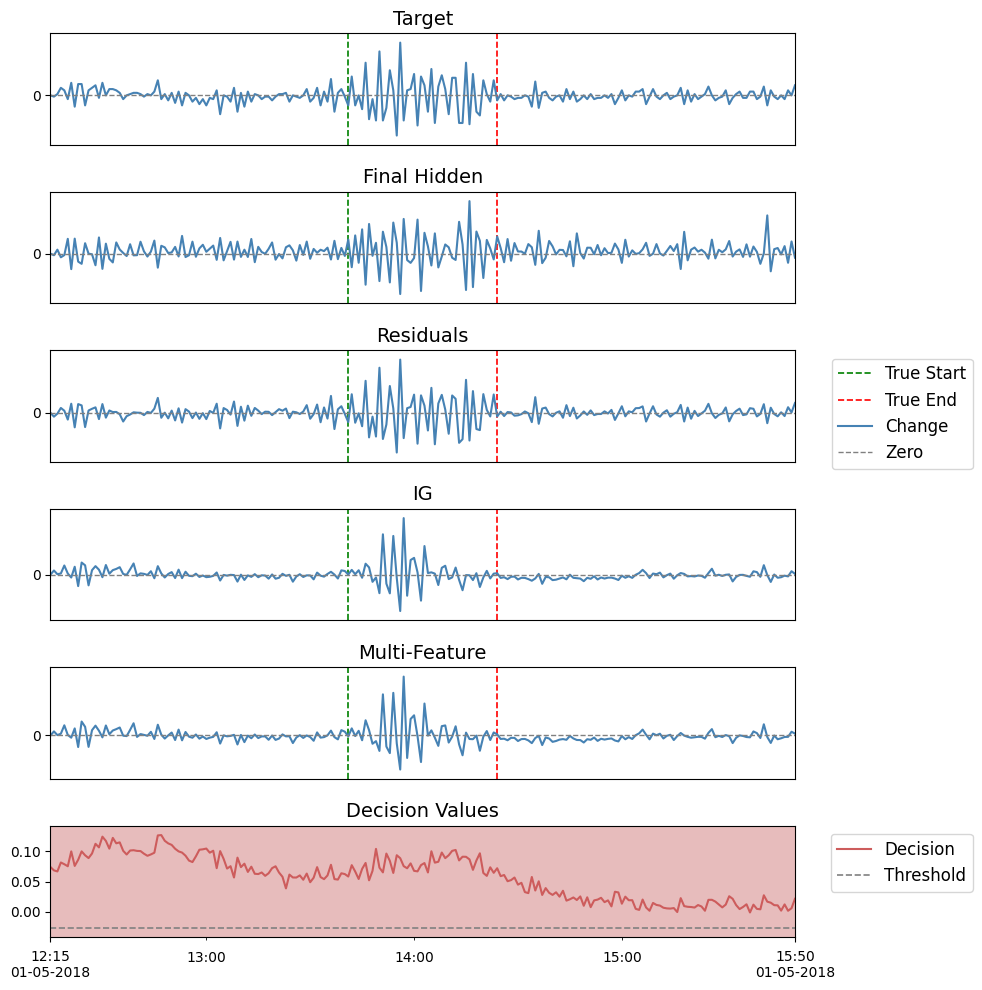

In [54]:

fig, axs = plt.subplots(len(methods)+1, 1, figsize=(10, 10))

# Inside your plotting function/loop
formatter = ticker.FormatStrFormatter('%.0f')  # Change to the desired format, e.g., '%.3f' for three decimal places

# Extract from the model outputs
start_idx = np.where(starttimes == show_start)[0][0]
end_idx = np.where(starttimes == show_end)[0][0]
data = outputs[start_idx:end_idx+1, :]

for i, method in enumerate(methods):

    # add background error spand
    #axs[i] = visualize_error_span(axs[i], data_dict['indicator_dict'], data_dict['start'], data_dict['end'], adjust='full-point')
    #axs[i, 1] = visualize_error_span(axs[i, 1], data_dict['indicator_dict'], data_dict['start'], data_dict['end'], adjust='full-point')

    # Show true start and stop with hline
    axs[i].axvline(starttime, color='green', linestyle='--', linewidth=1.2, label='True Start')
    axs[i].axvline(endtime, color='red', linestyle='--', linewidth=1.2, label='True End')


    # Extract the features
    features = data[:, column_2_idx[method.lower()]]
    diff1 = np.diff(features, axis=0) # calculate the diff 1 across the observations
    mean_diff1 = np.mean(diff1, axis=1) # mean across the dimensions
    mean_diff1 = np.insert(mean_diff1, 0, 0) # add zero as first element
    # visualize the mean diff
    axs[i].plot(show_timestamps, mean_diff1, color='steelblue', label="Change")
    axs[i].axhline(0, color='grey', linestyle='--', linewidth=1, label='Zero')
    # formatting
    #axs[i].set_ylabel(method, fontsize=12, rotation=0, labelpad=10, ha='right', va='center')
    min_max_diff_div = (max(mean_diff1) - min(mean_diff1)) / 10
    axs[i].set_ylim(mean_diff1.min()-min_max_diff_div, mean_diff1.max()+min_max_diff_div)
    axs[i].set_yticks([0])
    axs[i].yaxis.set_major_formatter(formatter)
    axs[i].set_xlim(show_start, show_end)
    axs[i].set_xticks([])
    axs[i].set_title(method, fontsize=14)
    if i == 2:
        axs[i].legend(loc='upper right', fontsize=12, bbox_to_anchor=(1.25, 1))


axs[i+1] = visualize_error_span(axs[i+1], indicator_dict, show_start, show_end, adjust='full-point')
# Extract the decision values
decision_values = results[method]['Decision Function'][start_idx:end_idx+1]
# Plot the decision function
axs[i+1].plot(show_timestamps, decision_values, color='indianred', label='Decision')
# get the optimal threshold
threshold = results[method]["Optimal Threshold"]
axs[i+1].axhline(threshold, color='grey', linestyle='--', label='Threshold', linewidth=1.2)
# formatting
decision_values = np.insert(decision_values, 0, threshold) # add threshold as first element
min_max_diff_div = (max(decision_values) - min(decision_values)) / 10
axs[i+1].set_ylim(decision_values.min()-min_max_diff_div, decision_values.max()+min_max_diff_div)  # Ensure unique y-axis limits
#axs[i, 1].set_yticks([0])
#axs[i, 1].yaxis.set_major_formatter(formatter)
axs[i+1].set_xlim(show_start, show_end)
axs[i+1].set_title('Decision Values', fontsize=14)
#axs[i+1].set_ylabel('Values', fontsize=12, rotation=0, labelpad=10, ha='right', va='center')
axs[i+1].legend(loc='upper right', fontsize=12, bbox_to_anchor=(1.25, 1))


# remove xticks
axs[-1] = set_meaningful_xticks(axs[-1], show_start, show_end)

plt.tight_layout()
plt.savefig(_save_folder / 'feature_diffs.png', dpi=150)
plt.show()
plt.close()


In [55]:
# ### Feature plot
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# # Extract from the model outputs
# start_idx = np.where(starttimes == starttime)[0][0]
# end_idx = np.where(starttimes == endtime)[0][0]

# Identify start and end indices
start_idx = np.where(starttimes == show_start)[0][0]
end_idx = np.where(starttimes == show_end)[0][0]


method = "Residuals"

# extract the output
data = outputs[:, column_2_idx[method.lower()]]
# the anomalous interval
anomalous_data = data[start_idx:end_idx+1, :]
anomalous_timestamps = pd.date_range(show_start, show_end, freq='1min')
# and get the target
target = outputs[:, column_2_idx['target']]
target = target[start_idx:end_idx+1].flatten()

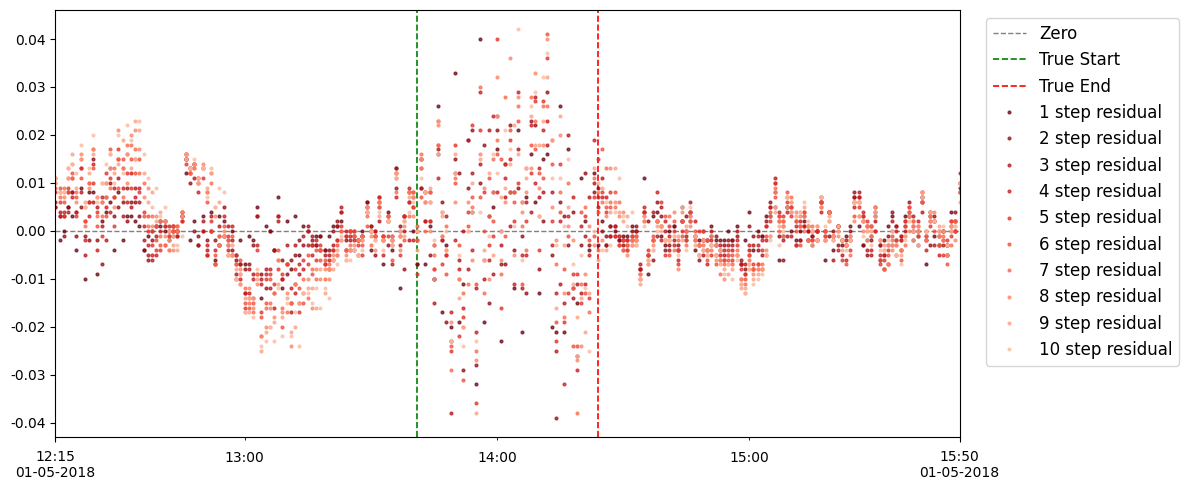

In [56]:

# Plot the time series
formatter = ticker.FormatStrFormatter('%.2f')  # Change to the desired format, e.g., '%.3f' for three decimal places
fig, ax = plt.subplots(1, 1, figsize=(12, 5))


# add a line at 0
ax.axhline(0, color='grey', linestyle='--', linewidth=1, label='Zero')
# formatting

ax.axvline(starttime, color='green', linestyle='--', linewidth=1.2, label='True Start')
ax.axvline(endtime, color='red', linestyle='--', linewidth=1.2, label='True End')


n_residuals = anomalous_data.shape[1]
    
cmap = cm.Reds
norm = mcolors.Normalize(vmin=-2, vmax=n_residuals)
for i in range(n_residuals):
    color = cmap(norm(n_residuals-i))  # Get color from colormap
    ax.plot(anomalous_timestamps, anomalous_data[:, i], 
            alpha=0.7, marker='o', markersize=2, linestyle='', 
            color=color,
            label=f'{i+1} step residual'
            )

#ax.set_ylabel('Residuals', fontsize=14, rotation=0, labelpad=10, ha='right', va='center')
# visualzie error span
#ax = visualize_error_span(ax, data_dict['indicator_dict'], data_dict['start'], data_dict['end'], adjust='full-point')
ax.set_xlim(data_dict['start'], data_dict['end'])
#ax.set_ylabel(unit)
# place legend outside
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=12)
ax.set_xticks([])
ax.yaxis.set_major_formatter(formatter)
ax = set_meaningful_xticks(ax, data_dict['start'], data_dict['end'])
plt.tight_layout()
plt.savefig(_save_folder / 'residual_plot.png', dpi=150)
plt.show()
plt.close()



In [57]:

def pca_analysis(method, outputs, column_2_idx, results, start_idx, end_idx):
    # extract the output
    data = outputs[:, column_2_idx[method.lower()]]
    
    # Perform PCA
    # Standardize the data
    scaler = StandardScaler()
    features = scaler.fit_transform(data)
    # Create a PCA instance
    pca = PCA(n_components=2)
    # Fit the model
    pca.fit(features)
    # Transform the data
    components = pca.transform(features)
    # variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by each component: {explained_variance}")
    print(f"Total explained variance: {np.sum(explained_variance)}")
    # the anomalous interval
    anomalous_data = features[start_idx:end_idx+1, :]
    anomalous_components = pca.transform(anomalous_data)
    
    # Visualize
    decision_values = results[method]['Decision Function']
    actual_filter = np.array(results['Actual']) == 1
    # set markers if actual or not
    #markers = ['o' if act == 1 else 'x' for act in actual]
    
    # visualize PCA
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    scatter = ax.scatter(components[~actual_filter, 0], components[~actual_filter, 1], label='Normal Data',
                        c=decision_values[~actual_filter], cmap='coolwarm', marker='o', s=5, alpha=0.7)
    ax.scatter(components[actual_filter, 0], components[actual_filter, 1], label='Synthetic Anomalies',
                        s=5, alpha=0.3,
                        #c=decision_values[actual_filter], cmap='coolwarm',
                        c='plum', marker='v', #edgecolor='black'
                        )
    #scatter = ax.scatter(components[:, 0], components[:, 1], alpha=0.7, s=5, c=decision_values, cmap='coolwarm')   

    # Plot the rest of the anomalous data in purple (or any color you want)
    anomalous_scatter = ax.scatter(anomalous_components[1:-1, 0], anomalous_components[1:-1, 1], label='Anomalous interval', 
                                c='purple', marker='o', s=10, alpha=1, edgecolor='none')

    # Connect anomalous points with lines (if you want to visualize the sequence or pattern)
    for i in range(1, len(anomalous_components)):
        ax.plot([anomalous_components[i-1, 0], anomalous_components[i, 0]],
                [anomalous_components[i-1, 1], anomalous_components[i, 1]], 
                color='purple', linestyle='-', alpha=0.4, linewidth=1, zorder=1)

    # Plot start and stop
    start_point = anomalous_components[0]
    end_point = anomalous_components[-1]
    start_scatter = ax.scatter(start_point[0], start_point[1], label='Anomaly start', c='green', marker='o', s=30, alpha=1, zorder=10)
    end_scatter = ax.scatter(end_point[0], end_point[1], label='Anomaly end', c='red', marker='o', s=30, alpha=1, zorder=10)

    # Set the labels
    ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)', fontsize=15)
    ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)', fontsize=15)
    cbar = plt.colorbar(scatter, ax=ax, 
                        orientation='vertical', pad=0.02,
                        shrink=0.7)   
    cbar.set_label('Decision Values', fontsize=14)
    # Add the legend
    ax.legend(loc='upper right', prop={'size': 12})
    plt.tight_layout()
    plt.savefig(_save_folder / f'pca_{method.lower()}.png', dpi=150)
    plt.show()
    plt.close()


In [58]:
# PCA

# Extract from the model outputs
start_idx = np.where(starttimes == starttime)[0][0]
end_idx = np.where(starttimes == endtime)[0][0]


Explained variance by each component: [0.435124 0.382156]
Total explained variance: 0.8172801545299491


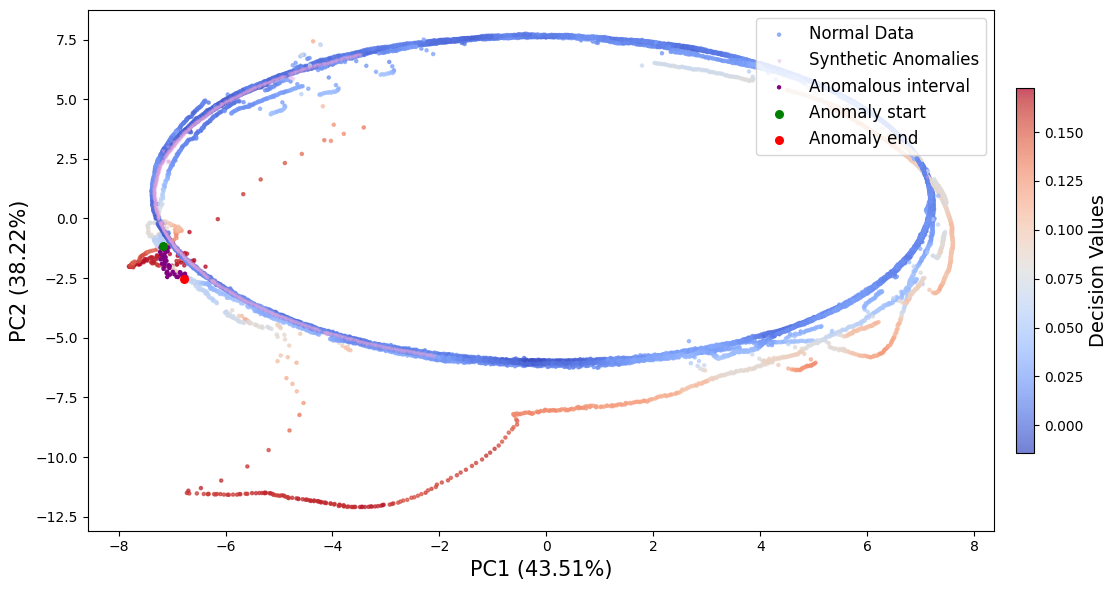

In [59]:

# Perform PCA analysis
method = "Final Hidden" # using only this method
pca_analysis(method, outputs, column_2_idx, results, start_idx, end_idx)


In [60]:
indicator_2_data_label = json.load(open(REFERENCE_DIR / 'indicator_2_data_label.json', 'r'))
indicator_2_data_label

{'0': 'Original',
 '1': 'Spike',
 '2': 'Noise',
 '3': 'Frozen',
 '4': 'Offset',
 '5': 'Drift'}

Explained variance by each component: [0.389844 0.182724]
Total explained variance: 0.5725683237642099


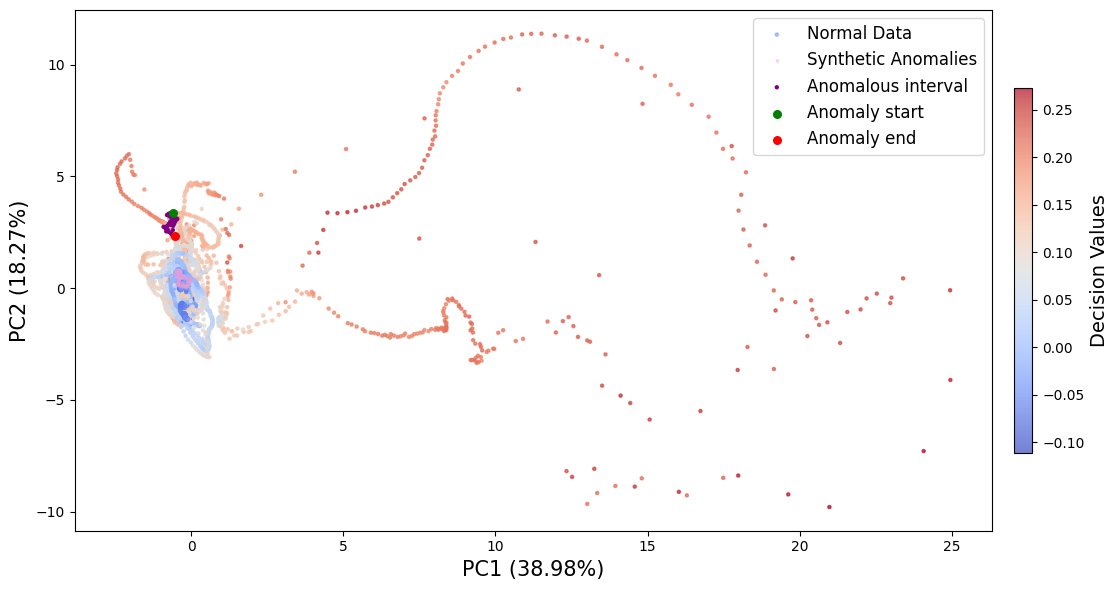

In [61]:


# Perform PCA analysis
method = "IG" # using only this method
pca_analysis(method, outputs, column_2_idx, results, start_idx, end_idx)



Explained variance by each component: [0.341621 0.291729]
Total explained variance: 0.6333493156709002


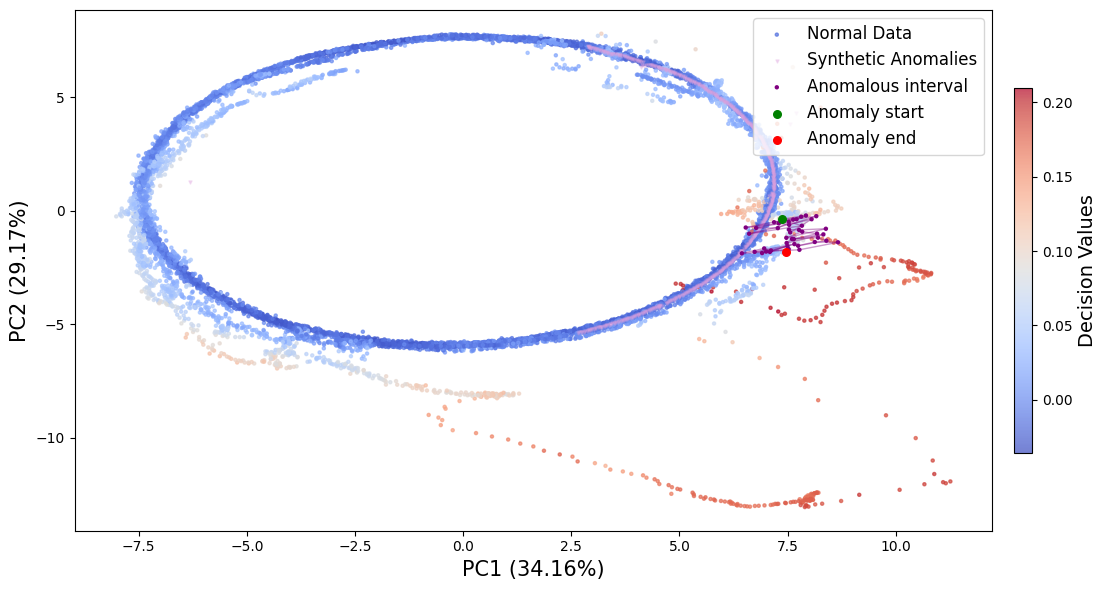

In [62]:

# Perform PCA analysis
method = "Multi-Feature" # using only this method
pca_analysis(method, outputs, column_2_idx, results, start_idx, end_idx)


In [63]:
raise ValueError("Stop here")   

ValueError: Stop here

### Identify detections

In [ ]:
# Get the start and end of each anomaly
indices_of_ones = [index for index, value in enumerate(results['Actual']) if value == 1]
_, anomaly_start_end = find_unterrupted_sequences(indices_of_ones, 0)

In [ ]:
# ignore sigma 3 and overall
#methods = methods[:-1]
print(methods)
_anomalies = data_label_hue_order[1:][::-1]
print(_anomalies)

['Target', 'Final Hidden', 'Residuals', 'IG', 'Multi-Feature']
['Spike', 'Noise', 'Frozen', 'Offset', 'Drift']


In [ ]:
binned_decision_values = {}
anomaly_intervals = {}
# For each method
for i, key in enumerate(methods):
    data_label = results['Data Label']
    binned_decision_values[key] = {}
    # For each
    for label in _anomalies:
        if label == 'Original':
            continue
        else:
            # Anomaly filter
            mask = (np.array(data_label) == label)
        
        # filter for starts based on the starts in _anomaly_start_end and mask
        start_end = [anomaly_start_end[i] for i, (start, end) in enumerate(anomaly_start_end) if mask[start]]
        # If empty then continue
        if len(start_end) == 0:
            continue

        # Get the decision values
        decision_values = get_decision_values(results, key, start_end, n_bins)
        binned_decision_values[key][label] = decision_values
        # Store the start times
        if i == 0:
            anomaly_intervals[label] = {
                "Starts": [results["Starttime"][start] for start, _ in start_end],
                "Ends": [results["Starttime"][end] for _, end in start_end]
            }
            #[results["Starttime"][start] for start, _ in start_end]

In [ ]:
# get filter anomalies in case of empty
_anomalies = [label for label in _anomalies if label in binned_decision_values[key]]
print(_anomalies)

['Spike', 'Noise', 'Frozen']


In [ ]:
detections = {
    'Most Accurate': {},
    'Least Accurate': {},
    'Most Certain Non-Anomaly': {},
}

# Ensure equal count per anomaly
for anomaly in _anomalies:
    counts = np.unique([len(binned_decision_values[method][anomaly]) for method in methods])
    assert len(counts) == 1, f"Counts are not equal for {anomaly}: {counts}"


# Get the most accurate detection and the least accurate detection
for anomaly in _anomalies:
    n_anomalies = len(binned_decision_values[methods[0]][anomaly])
    # For each instance of the anomaly type, extend the decision values
    decision_values = []
    for i in range(n_anomalies):
        decision_values.append(
            np.mean([binned_decision_values[method][anomaly][i] for method in methods])
        )
    # Find the most accurate detection
    most_accurate = np.argmax(decision_values)
    # Find the least accurate detection
    least_accurate = np.argmin(decision_values)
    detections['Most Accurate'][anomaly] = {
            'Avg. Decision Values': decision_values[most_accurate],
            'Start Time': anomaly_intervals[anomaly]["Starts"][most_accurate],
            'End Time': anomaly_intervals[anomaly]["Ends"][most_accurate]
    }
    detections['Least Accurate'][anomaly] = {
            'Avg. Decision Values': decision_values[least_accurate],
            'Start Time': anomaly_intervals[anomaly]["Starts"][least_accurate],
            'End Time': anomaly_intervals[anomaly]["Ends"][least_accurate]
    }

# Get the most certain non-anomaly
method = "Multi-Feature" # using only this method
n_top = 5

# Get the start and end of each anomaly
indices_of_ones = [index for index, value in enumerate(results['Actual']) if value == 1]
_, anomaly_start_end = find_unterrupted_sequences(indices_of_ones, 0)

# Get the start and end of each anomaly
indices_of_ones = [index for index, value in enumerate(results[method]["Predicted"].astype(int)) if value == 1]
_, predicted_start_end = find_unterrupted_sequences(indices_of_ones, 0)


decision_values = []
start_end = []
for start, end in predicted_start_end:
    # # Ensure not part of an anomaly
    # if np.any([start <= anomaly[0] <= end for anomaly in anomaly_start_end]):
    #     continue
    def intervals_overlap(start1, end1, start2, end2):
        return not (end1 < start2 or end2 < start1)

    if np.any([intervals_overlap(start, end, anomaly[0], anomaly[1]) for anomaly in anomaly_start_end]):
        continue
    # Get the decision values
    decision_values.append(results[method]['Decision Function'][start:end+1].mean())
    start_end.append((start, end))

# select n top based on selected to min 
n_possible = len(decision_values)
n_top = min(n_top, n_possible)

sorted_indices = np.argsort(decision_values)[::-1]  # Sort indices in descending order

for top in range(n_top):
    most_certain_non_anomaly = sorted_indices[top]
    #most_certain_non_anomaly = np.argsort(decision_values)[-(top+1)]
    detections['Most Certain Non-Anomaly'][f'Top {top+1}'] = {
        'Avg. Decision Values': decision_values[most_certain_non_anomaly],
        'Start Time': results['Starttime'][start_end[most_certain_non_anomaly][0]],
        'End Time': results['Starttime'][start_end[most_certain_non_anomaly][1]]
    }





### Difference vs. decision function plot

In [ ]:
from fault_management_uds.get_detection import load_model_outputs
from fault_management_uds.data.dataset import load_data, load_dataframe_from_HDF5
from fault_management_uds.plots import visualize_error_span, set_meaningful_xticks

from fault_management_uds.data.load import import_metadata
import json

metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')

In [ ]:
# Load the model outputs
outputs, column_2_idx = load_model_outputs(anomalous_path / data_type)
# set all the column 2 idx keys to lower
#column_2_idx = {key.lower(): value for key, value in column_2_idx.items()}

Outputs: (9213, 90)
Column 2 idx: ['Starttime', 'Valid index', 'Data label', 'Target', 'Residual', 'Prediction', 'Final hidden', 'IG', 'Residuals']
Outputs after features: (9212, 90)


In [ ]:
starttimes = pd.to_datetime(outputs[:, column_2_idx['starttime']].flatten())
# Identify start and end indices
#start_idx = np.where(starttimes == show_start)[0][0]

In [ ]:
show_start = starttimes[10]
start_idx = np.where(starttimes == show_start)[0][0]
start_idx

10

In [ ]:
detections['Most Accurate'].keys()

dict_keys(['Spike', 'Noise', 'Frozen'])

In [ ]:
# Select what to plot: ['Most Accurate', 'Least Accurate', 'Most Certain Non-Anomaly']
detection_theme = "Most Accurate"
# Select the detection
# Either: 'Spike', 'Noise', 'Frozen', 'Offset', 'Drift'
# Or: 'Top 1', 'Top 2'...
detection_type = "Noise"
# create a save folder
_save_folder = save_folder / detection_theme / detection_type
os.makedirs(_save_folder, exist_ok=True)

# Extract
detection = detections[detection_theme][detection_type]
_starttime = detection['Start Time']
starttime = pd.to_datetime(_starttime)
_endtime = detection['End Time']
endtime = pd.to_datetime(_endtime)
timestamps = pd.date_range(starttime, endtime, freq='1min')
detection

{'Avg. Decision Values': 0.11665705606403928,
 'Start Time': 1525182060000000000,
 'End Time': 1525184640000000000}

#### Visualize the actual time line

In [ ]:
# Get the data to visualize anomaly
go_back_forth = 20 # minutes
show_start = starttime - pd.Timedelta(minutes=go_back_forth)
show_end = endtime + pd.Timedelta(minutes=go_back_forth)
show_timestamps = pd.date_range(start=show_start, end=show_end, freq='1min')
# create the indicator
indicator = np.zeros(len(show_timestamps))
mask = (show_timestamps >= starttime) & (show_timestamps <= endtime)
indicator[mask] = 1

In [ ]:
# Extract from the model outputs
starttimes = pd.to_datetime(outputs[:, column_2_idx['starttime']].flatten())
# Identify start and end indices
start_idx = np.where(starttimes == show_start)[0][0]
end_idx = np.where(starttimes == show_end)[0][0]
# Extract the data
data = outputs[start_idx:end_idx+1, :]
polluted_data = pd.DataFrame(data[:, column_2_idx['target']], index=show_timestamps, columns=['value'])

In [ ]:

# Get the data
sensor_name = config['dataset_args']['endogenous_vars'][0]
true_data, _, _, _ = load_dataframe_from_HDF5(
    config['dataset_args']['data_file_path'], 
    #f"combined_data/{config['dataset_args']['data_group']}", 
    f"combined_data/clean", 
    #columns=config['dataset_args']['endogenous_vars'],
    columns=['5425', sensor_name],
    starttime=show_start, 
    endtime=show_end, 
    complete_range=True
)
true_data.rename(columns={config['dataset_args']['endogenous_vars'][0]: 'value'}, inplace=True)


unit = metadata[metadata['IdMeasurement'] == sensor_name]['UnitAlias'].values[0]


In [ ]:
data_dict = {
    'original': true_data,
    '5425': true_data,
    'polluted': polluted_data,
    'start': show_start,
    'end': show_end,
    'indicator_dict': {
        'indicator': indicator,
        'colormap': {
            0: 'none',
            1: 'firebrick',
        }
    }
}

In [ ]:
def visualize_rain(ax, title, data_dict, marker='o', linewidth=1):
    ax.set_title(title, fontsize=20)
    ### Visualize rain data
    rain_gauge = '5425'
    ax.plot(data_dict["original"][rain_gauge].index, data_dict["original"][rain_gauge],
        label=f'Rain gauge {rain_gauge}', color='darkblue',
        linewidth=linewidth, linestyle='-', 
        marker=marker, markersize=1, alpha=1)
    ax.set_ylabel('Rain (mm)')
    ax.legend(loc='upper right')
    ax.set_xticks([])
    # set y limits based on 0 and max wrt both
    ax.set_ylim(-0.5, data_dict["original"]['5425'].max()+1)
    ax.set_xlim(data_dict['start'], data_dict['end'])
    return ax

def visualize_injected_synthetics(ax, title, data_dict, unit, marker='o'):

    # visualize the sensor data; severities
    ax.set_title(title, fontsize=20)
    ax.plot(data_dict['original'].index, data_dict['original'].value, 
        label='Original data', color='grey', 
        linewidth=1, linestyle='-', 
        marker='', markersize=1, alpha=1)

    ax.plot(data_dict['polluted'].index, data_dict['polluted'].value, 
        label='Erroneous data', color='grey', 
        linewidth=2, linestyle='-', 
        marker=marker, markersize=2, alpha=1)
    # visualzie error span
    ax = visualize_error_span(ax, data_dict['indicator_dict'], data_dict['start'], data_dict['end'], adjust='full-point')
    ax.set_xlim(data_dict['start'], data_dict['end'])
    ax.set_ylabel(unit)
    ax.legend()
    ax.set_xticks([])
    return ax



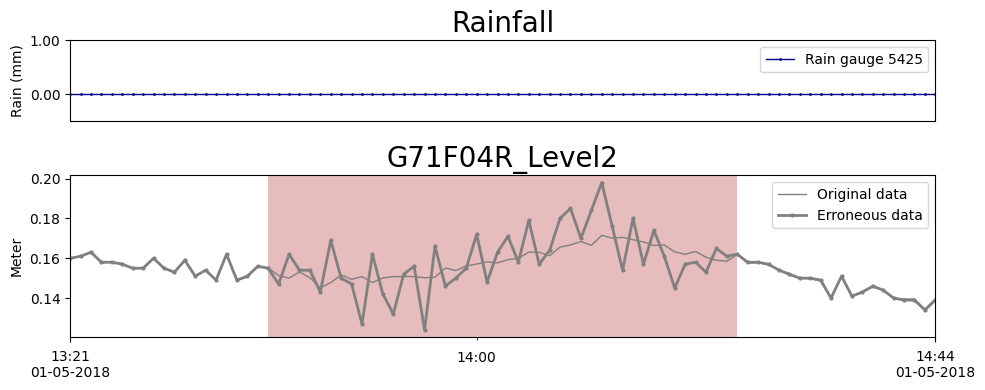

In [ ]:
# Plot the time series
formatter = ticker.FormatStrFormatter('%.2f')  # Change to the desired format, e.g., '%.3f' for three decimal places
fig, axs = plt.subplots(2, 1, figsize=(10, 4), height_ratios=[1, 2])
axs[0] = visualize_rain(axs[0], 'Rainfall', data_dict)
axs[0].yaxis.set_major_formatter(formatter)
axs[1] = visualize_injected_synthetics(axs[1], sensor_name, data_dict, unit)
axs[1].yaxis.set_major_formatter(formatter)
axs[-1] = set_meaningful_xticks(axs[-1], data_dict['start'], data_dict['end'])
plt.tight_layout()
plt.savefig(_save_folder / 'anomaly_visualization.png', dpi=150)
plt.show()
plt.close()


#### Visualize the difference plot

In [ ]:
# create the multi-feature indices
all_feature_indices = []
for feature in methods[:-1]:
    all_feature_indices.extend(column_2_idx[feature.lower()])
# add to column_2_idx
column_2_idx['multi-feature'] = all_feature_indices

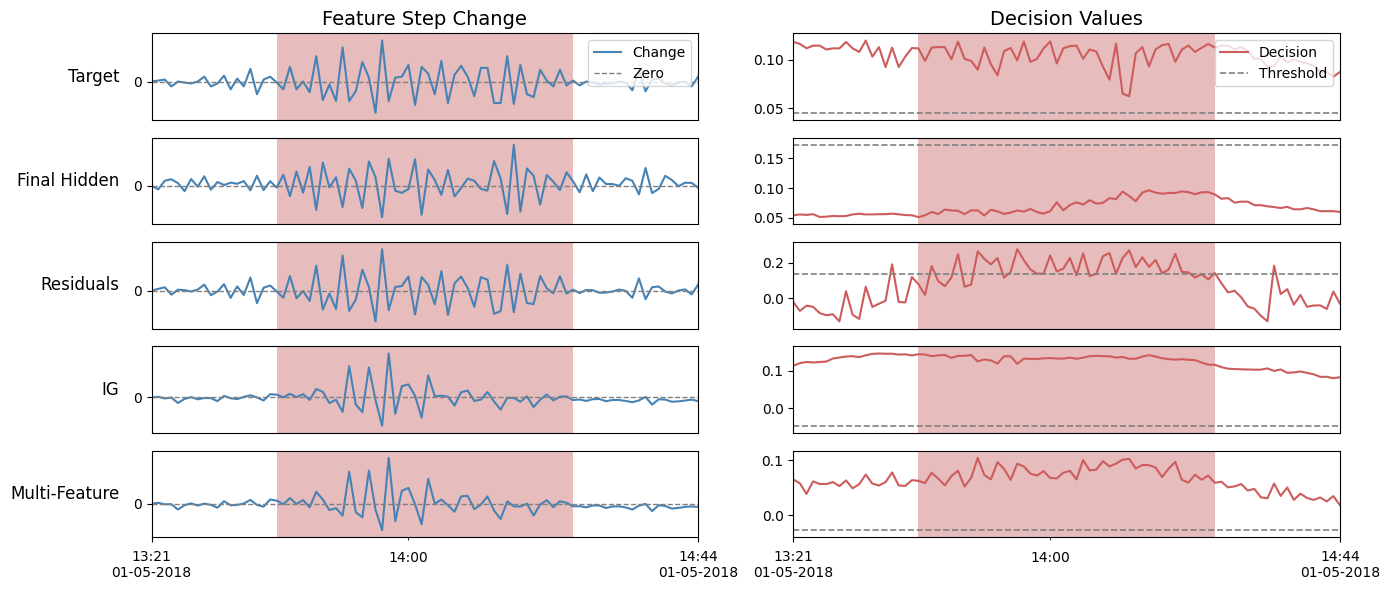

In [ ]:

fig, axs = plt.subplots(len(methods), 2, figsize=(14, 6))

# Inside your plotting function/loop
formatter = ticker.FormatStrFormatter('%.0f')  # Change to the desired format, e.g., '%.3f' for three decimal places

# Extract from the model outputs
start_idx = np.where(starttimes == show_start)[0][0]
end_idx = np.where(starttimes == show_end)[0][0]
data = outputs[start_idx:end_idx+1, :]

for i, method in enumerate(methods):

    # add background error spand
    axs[i, 0] = visualize_error_span(axs[i, 0], data_dict['indicator_dict'], data_dict['start'], data_dict['end'], adjust='full-point')
    axs[i, 1] = visualize_error_span(axs[i, 1], data_dict['indicator_dict'], data_dict['start'], data_dict['end'], adjust='full-point')


    # Extract the features
    features = data[:, column_2_idx[method.lower()]]
    diff1 = np.diff(features, axis=0) # calculate the diff 1 across the observations
    mean_diff1 = np.mean(diff1, axis=1) # mean across the dimensions
    mean_diff1 = np.insert(mean_diff1, 0, 0) # add zero as first element
    # visualize the mean diff
    axs[i, 0].plot(show_timestamps, mean_diff1, color='steelblue', label='Change')
    axs[i, 0].axhline(0, color='grey', linestyle='--', linewidth=1, label='Zero')
    # formatting
    axs[i, 0].set_ylabel(method, fontsize=12, rotation=0, labelpad=10, ha='right', va='center')
    min_max_diff_div = (max(mean_diff1) - min(mean_diff1)) / 10
    axs[i, 0].set_ylim(mean_diff1.min()-min_max_diff_div, mean_diff1.max()+min_max_diff_div)
    axs[i, 0].set_yticks([0])
    axs[i, 0].yaxis.set_major_formatter(formatter)
    axs[i, 0].set_xlim(show_start, show_end)


    # Extract the decision values
    decision_values = results[method]['Decision Function'][start_idx:end_idx+1]
    # Plot the decision function
    axs[i, 1].plot(show_timestamps, decision_values, label='Decision', color='indianred')
    # get the optimal threshold
    threshold = results[method]["Optimal Threshold"]
    axs[i, 1].axhline(threshold, color='grey', linestyle='--', label='Threshold', linewidth=1.2)
    # formatting
    decision_values = np.insert(decision_values, 0, threshold)
    min_max_diff_div = (max(decision_values) - min(decision_values)) / 10
    axs[i, 1].set_ylim(decision_values.min()-min_max_diff_div, decision_values.max()+min_max_diff_div)  # Ensure unique y-axis limits
    #axs[i, 1].set_yticks([0])
    #axs[i, 1].yaxis.set_major_formatter(formatter)
    axs[i, 1].set_xlim(show_start, show_end)

    if i == 0:
        # Set the titles for each subplot
        axs[i, 0].set_title('Feature Step Change', fontsize=14)
        axs[i, 0].legend(loc='upper right')
        axs[i, 1].set_title('Decision Values', fontsize=14)
        axs[i, 1].legend(loc='upper right')

    # remove xticks
    axs[i, 0].set_xticks([])
    axs[i, 1].set_xticks([])
    #break
axs[-1, 0] = set_meaningful_xticks(axs[-1, 0], show_start, show_end)
axs[-1, 1] = set_meaningful_xticks(axs[-1, 1], show_start, show_end)


plt.tight_layout()
plt.savefig(_save_folder / 'feature_diffs.png', dpi=150)
plt.show()
plt.close()

### Feature plots

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [ ]:
# # Extract from the model outputs
# start_idx = np.where(starttimes == starttime)[0][0]
# end_idx = np.where(starttimes == endtime)[0][0]

# Identify start and end indices
start_idx = np.where(starttimes == show_start)[0][0]
end_idx = np.where(starttimes == show_end)[0][0]

In [ ]:
method = "Residuals"

In [ ]:
# extract the output
data = outputs[:, column_2_idx[method.lower()]]
# the anomalous interval
anomalous_data = data[start_idx:end_idx+1, :]
anomalous_timestamps = pd.date_range(show_start, show_end, freq='1min')
# and get the target
target = outputs[:, column_2_idx['target']]
target = target[start_idx:end_idx+1].flatten()

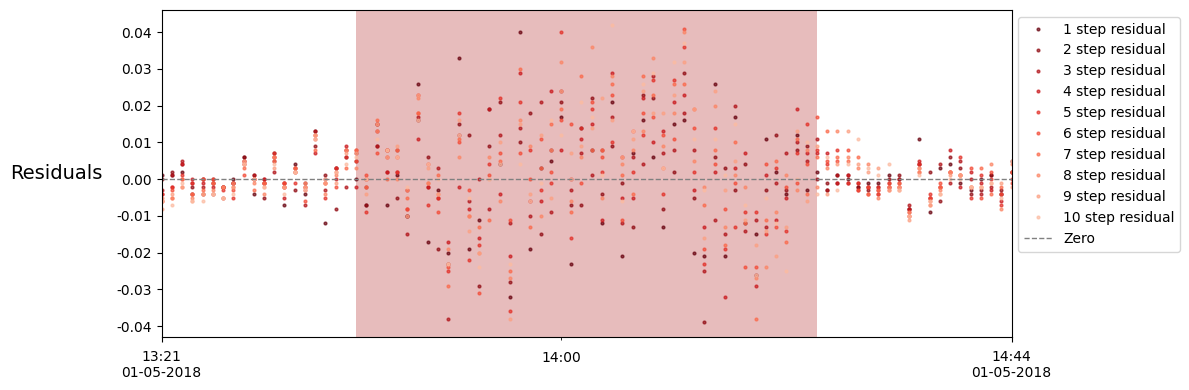

In [ ]:
# Plot the time series
formatter = ticker.FormatStrFormatter('%.2f')  # Change to the desired format, e.g., '%.3f' for three decimal places
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# ax.plot(data_dict['polluted'].index, data_dict['polluted'].value, 
#     label='Erroneous data', color='grey', 
#     linewidth=2, linestyle='-', 
#     marker='o', markersize=2, alpha=1)

# plot the residuals
n_residuals = anomalous_data.shape[1]

# cmap = cm.Blues
# norm = mcolors.Normalize(vmin=-2, vmax=n_residuals)
# for i in range(n_residuals):
#     color = cmap(norm(n_residuals-i))  # Get color from colormap
#     ax.plot(anomalous_timestamps, -(anomalous_data[:, i]-target), 
#             alpha=0.7, marker='o', markersize=2, linestyle='', 
#             #color=color
#             color='red'
#             )

# ymin, ymax = ax.get_ylim()
# y_center = (ymin + ymax) / 2
# cmap = cm.Reds
# norm = mcolors.Normalize(vmin=-2, vmax=n_residuals)
# for i in range(n_residuals):
#     color = cmap(norm(n_residuals-i))  # Get color from colormap
#     ax.plot(anomalous_timestamps, y_center + anomalous_data[:, i], 
#             alpha=0.7, marker='o', markersize=2, linestyle='', color=color)
    
cmap = cm.Reds
norm = mcolors.Normalize(vmin=-2, vmax=n_residuals)
for i in range(n_residuals):
    color = cmap(norm(n_residuals-i))  # Get color from colormap
    ax.plot(anomalous_timestamps, anomalous_data[:, i], 
            alpha=0.7, marker='o', markersize=2, linestyle='', 
            color=color,
            label=f'{i+1} step residual'
            )

# add a line at 0
ax.axhline(0, color='grey', linestyle='--', linewidth=1, label='Zero')
# formatting
ax.set_ylabel('Residuals', fontsize=14, rotation=0, labelpad=10, ha='right', va='center')

# visualzie error span
ax = visualize_error_span(ax, data_dict['indicator_dict'], data_dict['start'], data_dict['end'], adjust='full-point')
ax.set_xlim(data_dict['start'], data_dict['end'])
#ax.set_ylabel(unit)
# place legend outside
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xticks([])
ax.yaxis.set_major_formatter(formatter)
ax = set_meaningful_xticks(ax, data_dict['start'], data_dict['end'])
plt.tight_layout()
plt.savefig(_save_folder / 'residual_plot.png', dpi=150)
plt.show()
plt.close()

PCA

In [ ]:
# Extract from the model outputs
start_idx = np.where(starttimes == starttime)[0][0]
end_idx = np.where(starttimes == endtime)[0][0]

In [ ]:
def pca_analysis(method, outputs, column_2_idx, results, start_idx, end_idx):
    # extract the output
    data = outputs[:, column_2_idx[method.lower()]]
    
    # Perform PCA
    # Standardize the data
    scaler = StandardScaler()
    features = scaler.fit_transform(data)
    # Create a PCA instance
    pca = PCA(n_components=2)
    # Fit the model
    pca.fit(features)
    # Transform the data
    components = pca.transform(features)
    # variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by each component: {explained_variance}")
    print(f"Total explained variance: {np.sum(explained_variance)}")
    # the anomalous interval
    anomalous_data = features[start_idx:end_idx+1, :]
    anomalous_components = pca.transform(anomalous_data)
    
    # Visualize
    decision_values = results[method]['Decision Function']
    # visualize PCA
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    # Plot the components
    scatter = ax.scatter(components[:, 0], components[:, 1], alpha=0.7, s=5, c=decision_values, cmap='coolwarm')

    # Plot the rest of the anomalous data in purple (or any color you want)
    anomalous_scatter = ax.scatter(anomalous_components[1:-1, 0], anomalous_components[1:-1, 1], label='Anomalous interval', 
                                c='purple', marker='o', s=10, alpha=0.5, edgecolor='none')

    # Connect anomalous points with lines (if you want to visualize the sequence or pattern)
    for i in range(1, len(anomalous_components)):
        ax.plot([anomalous_components[i-1, 0], anomalous_components[i, 0]],
                [anomalous_components[i-1, 1], anomalous_components[i, 1]], 
                color='purple', linestyle='-', alpha=0.2, linewidth=1, zorder=1)

    # Plot start and stop
    start_point = anomalous_components[0]
    end_point = anomalous_components[-1]
    start_scatter = ax.scatter(start_point[0], start_point[1], label='Anomaly start', c='green', marker='o', s=30, alpha=0.7, zorder=10)
    end_scatter = ax.scatter(end_point[0], end_point[1], label='Anomaly end', c='red', marker='o', s=30, alpha=0.7, zorder=10)

    # Set the labels
    ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)', fontsize=15)
    ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)', fontsize=15)
    cbar = plt.colorbar(scatter, ax=ax, 
                        orientation='vertical', pad=0.02,
                        shrink=0.7)   
    cbar.set_label('Decision Values', fontsize=14)
    # Add the legend
    ax.legend(loc='upper right', prop={'size': 12})
    plt.tight_layout()
    plt.savefig(_save_folder / f'pca_{method.lower()}.png', dpi=150)
    plt.show()
    plt.close()

Explained variance by each component: [0.435124 0.382156]
Total explained variance: 0.8172801545299491


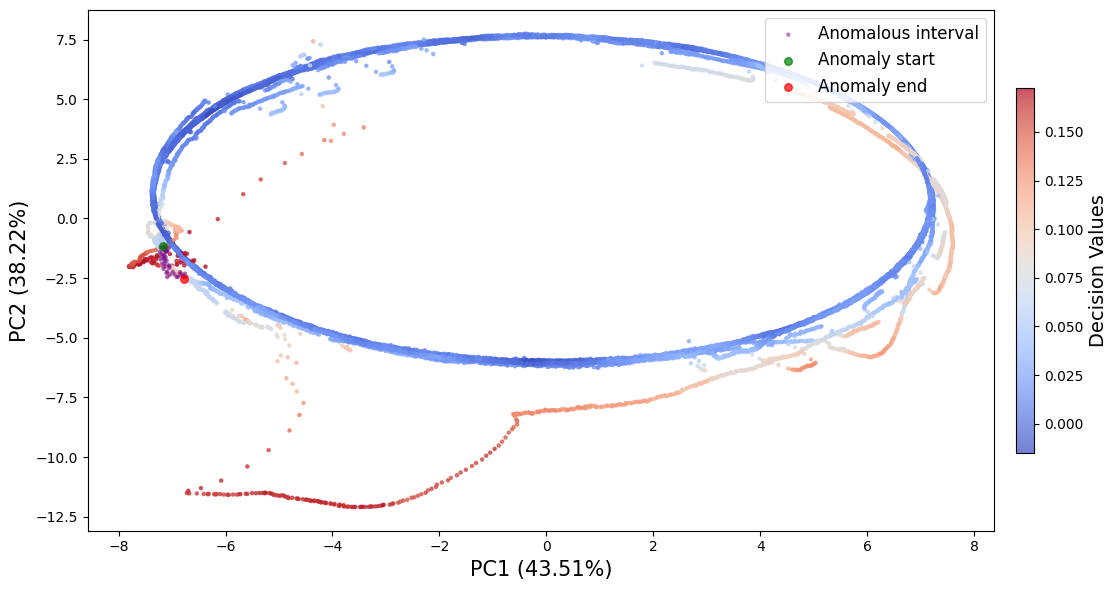

In [ ]:
# Perform PCA analysis
method = "Final Hidden" # using only this method
pca_analysis(method, outputs, column_2_idx, results, start_idx, end_idx)

Explained variance by each component: [0.389844 0.182724]
Total explained variance: 0.5725683237642099


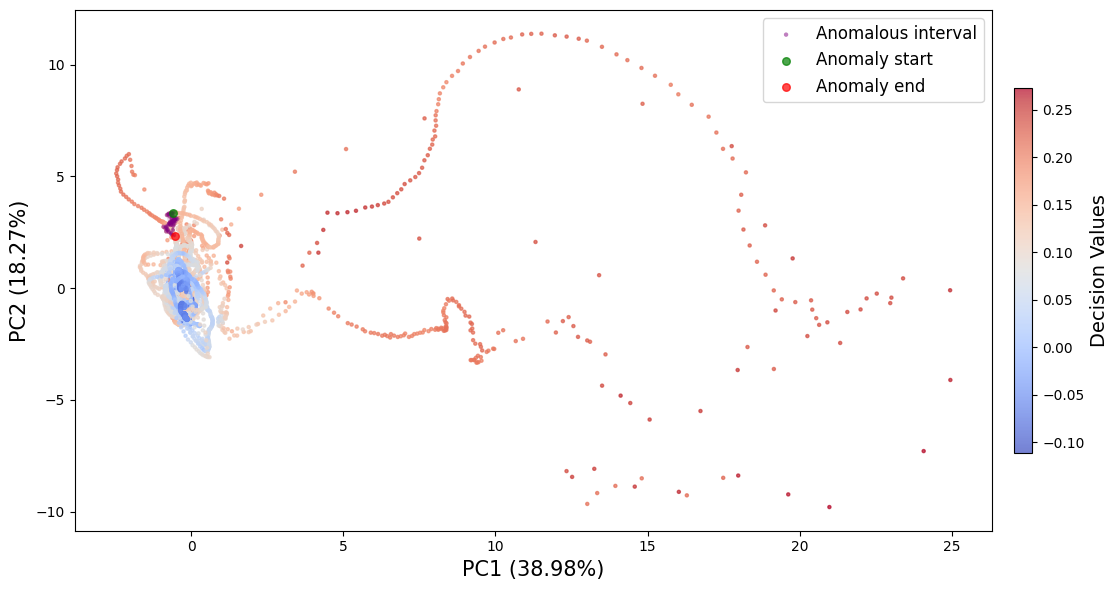

In [ ]:
# Perform PCA analysis
method = "IG" # using only this method
pca_analysis(method, outputs, column_2_idx, results, start_idx, end_idx)

Explained variance by each component: [0.341621 0.291729]
Total explained variance: 0.6333493156709002


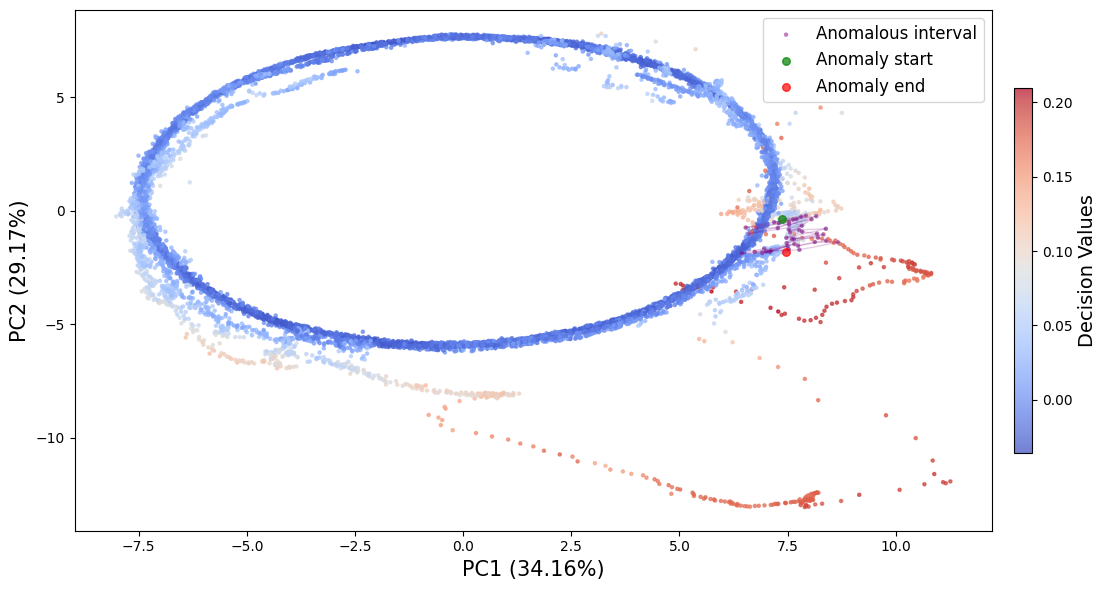

In [ ]:
# Perform PCA analysis
method = "Multi-Feature" # using only this method
pca_analysis(method, outputs, column_2_idx, results, start_idx, end_idx)